### Step 1. 
Choose variables for sampling from your dataset (overall – about 10 variables, 3-4 – target variables, the rest - predictors).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
from copy import  copy
import networkx as nx
import pgmpy
import bnlearn as bn
from pgmpy.estimators import HillClimbSearch, K2Score, BicScore
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.base import DAG
from pgmpy.inference import VariableElimination
from sklearn.metrics import accuracy_score
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import arcsine, weibull_max,rice, norm, rdist, skewnorm
import warnings
warnings.filterwarnings('ignore')
df=pd.read_csv('data.csv')

In /usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-d

In [2]:
df=pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      174389 non-null  float64
 1   artists           174389 non-null  object 
 2   danceability      174389 non-null  float64
 3   duration_ms       174389 non-null  int64  
 4   energy            174389 non-null  float64
 5   explicit          174389 non-null  int64  
 6   id                174389 non-null  object 
 7   instrumentalness  174389 non-null  float64
 8   key               174389 non-null  int64  
 9   liveness          174389 non-null  float64
 10  loudness          174389 non-null  float64
 11  mode              174389 non-null  int64  
 12  name              174389 non-null  object 
 13  popularity        174389 non-null  int64  
 14  release_date      174389 non-null  object 
 15  speechiness       174389 non-null  float64
 16  tempo             17

In [3]:
pgmpy.__version__

'0.1.14'

In [4]:
df=df.convert_dtypes()

In [5]:
subsample = ['acousticness', 'danceability',  'energy','liveness',\
             'loudness','popularity', 'year','tempo', 'speechiness', 'valence']

In [6]:
predictors =['energy','liveness','loudness','year','tempo', 'speechiness', 'valence']

In [7]:
target = ['acousticness', 'danceability', 'popularity']

In [8]:
final_target = ['popularity']

In [9]:
df.isnull().sum()

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

In [10]:
df=df[subsample]

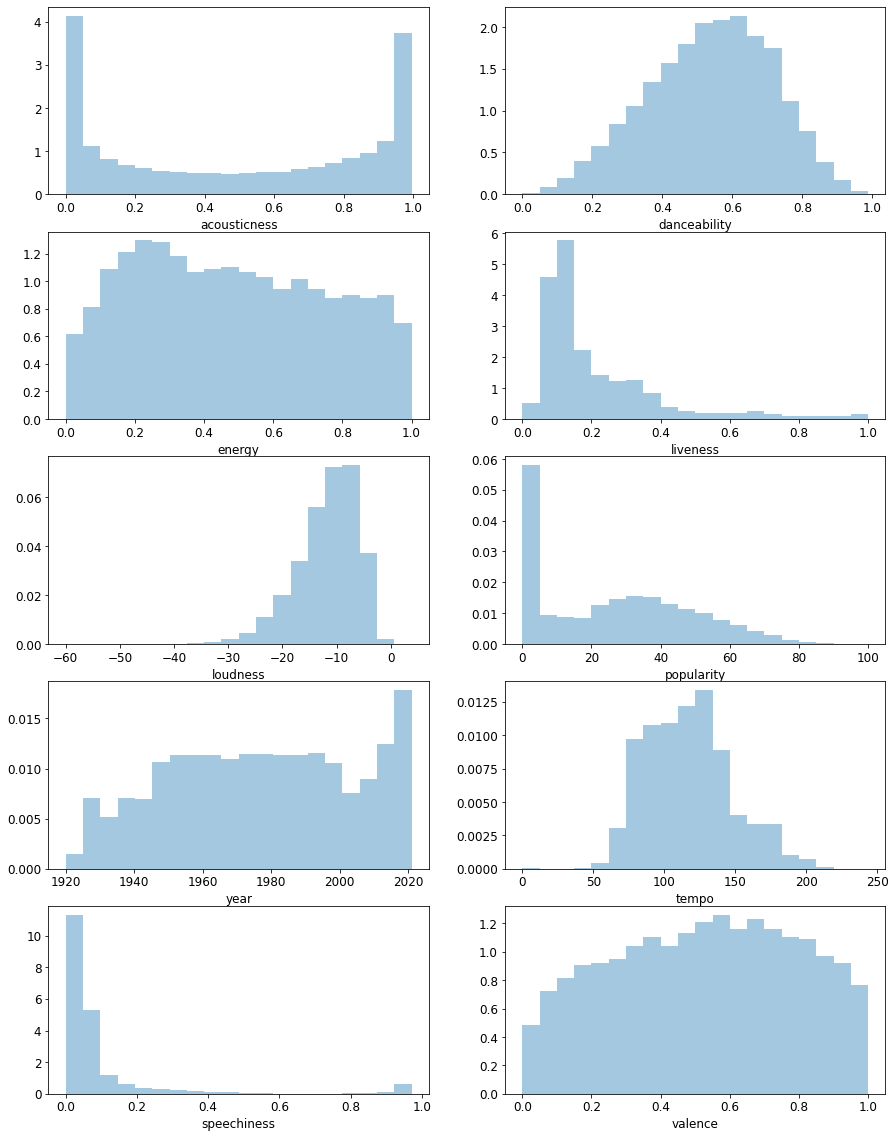

In [11]:
plt.rcParams['font.size'] = 12.0
fig, axs = plt.subplots(5, 2, figsize=(15, 20),squeeze=False)
axs=axs.flat
for num,col in enumerate(list(df.columns)):
    sns.distplot(df[col], kde=False,norm_hist=True,bins=20, ax=axs[num])
plt.show()     

In [12]:
# popularity_params =[1.2774985872782438, -5.3193397050856435, 22.708094733743472]#rice
# acoustic_param=[-0.04127103947489073, 1.037271039474891]#arcsine
# dance_param=[2.803768118029549, 0.9915153402036931, 0.5109384081817685]#weibull_max

In [13]:
def ks_test(data, distribution, params, alpha = 0.05, N = 50):
    ks = stats.kstest(data.sample(N), distribution, params, N)
    if ks[1] > alpha:
        print(f'Kolmogorov test passed. Under the null hypothesis,\n the two {distribution} distributions are identical')
    else:
        print(f"Kolmogorov test failed. Hypothesis about {distribution} is false")
    print('\n',ks)
def cvm_test(data, distribution, params, alpha = 0.05):
    cvm = stats.cramervonmises(data.sample(50), distribution, params)
    if cvm.pvalue > alpha: 
        print(f"Cramer-von-Mises test passed. Hypothesis about that distribution \n have cumulative {distribution} distribution is true")
    else:
        print(f"Cramer-von-Mises failed. We reject the null hypothesis \n that the observed sample is drawn from a {distribution} distribution")
    print('\n',cvm)

In [14]:
def statistical_tests(data, distribution, params, alpha = 0.05, N = 50):
    ks_test(data, distribution, params, alpha, N = 50)
    print('\n')
    cvm_test(data, distribution, params, alpha)

In [15]:
dance_param=weibull_max.fit(df['danceability'])
statistical_tests(df['danceability'], 'weibull_max', dance_param)

Kolmogorov test passed. Under the null hypothesis,
 the two weibull_max distributions are identical

 KstestResult(statistic=0.08990109225277915, pvalue=0.780372217555567)


Cramer-von-Mises failed. We reject the null hypothesis 
 that the observed sample is drawn from a weibull_max distribution

 CramerVonMisesResult(statistic=0.6280625244607702, pvalue=0.018698277694168763)


In [16]:
acoustic_param=arcsine.fit(df['acousticness'])
statistical_tests(df['acousticness'], 'arcsine', acoustic_param)

Kolmogorov test passed. Under the null hypothesis,
 the two arcsine distributions are identical

 KstestResult(statistic=0.14406253415456705, pvalue=0.2275536251038197)


Cramer-von-Mises failed. We reject the null hypothesis 
 that the observed sample is drawn from a arcsine distribution

 CramerVonMisesResult(statistic=0.7090565731226918, pvalue=0.011772698453237473)


In [17]:
popularity_params=rice.fit(df[df['popularity']!=0].popularity.astype('float'))
statistical_tests((df[df['popularity']!=0].popularity.astype('float')), 'rice', popularity_params)

Kolmogorov test passed. Under the null hypothesis,
 the two rice distributions are identical

 KstestResult(statistic=0.12628608602327762, pvalue=0.37129338686193303)


Cramer-von-Mises test passed. Hypothesis about that distribution 
 have cumulative rice distribution is true

 CramerVonMisesResult(statistic=0.054007520886681856, pvalue=0.8538083375085583)


### Step 2. 
Using univariate parametric distributions that were fitted in Lab#1 make sampling of chosen target variables. Use for this 2 different sampling methods.


In [18]:
def inverse_transform_sampling(n, dist, param):
    gen=np.random.uniform(size=n)
    rv=dist(*param)
    return rv.ppf(gen)

In [19]:
def accept_rejection_sampling(p_dist, p_params, q_dist, q_params, a, b, iters=1000):
    def p(x):
        return p_dist.pdf(x, *p_params)

    def q(x):
        return q_dist.pdf(x,*q_params)

    x = np.arange(a, b)
    k = max(p(x) / q(x))
    samples = []

    for i in range(iters):
        z = q_dist.rvs(*q_params, size=1)
        u = np.random.uniform(0, k*q(z))

        if u <= p(z):
            samples.append(z)

    return np.array(samples)

In [20]:
def qns(data):
    percs = np.linspace(0, 100, 10)
    qn= np.percentile(data, percs)
    return qn
def qq_plot(qn_first, qn_second, distribution, title = '', ax=axs):
    min_qn = np.min([qn_first.min(), qn_second.min()])
    max_qn = np.max([qn_first.max(), qn_second.max()])
    x = np.linspace(0, max_qn*1.05)
    ax.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
    ax.plot(x, x, color="k", ls="--")
    ax.set_xlim(0, np.max(x)) 
    ax.set_ylim(0, np.max(x))
    ax.set_xlabel(f'Sampled distribution', fontsize=15)
    ax.set_ylabel(f'Given ({distribution}) distribution', fontsize=15)
    ax.set_title(title, fontsize=15)

#### Inverse transform sampling

In [21]:
sample_acousticness=inverse_transform_sampling(10000,arcsine, acoustic_param)
sample_danceability=inverse_transform_sampling(10000,weibull_max, dance_param)
sample_popularity=inverse_transform_sampling(10000,rice,popularity_params)

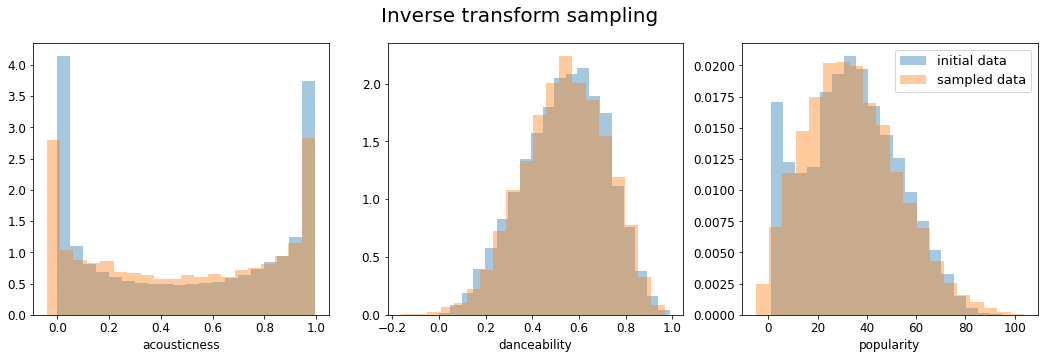

In [22]:
fig, axs = plt.subplots(1,3, figsize=(18, 5))
axs=axs.flat
sns.distplot(df['acousticness'],bins=20,kde=False, norm_hist=True, ax=axs[0], label='initial data')
sns.distplot(sample_acousticness,bins=20,kde=False,norm_hist=True,ax=axs[0], label='sampled data')
sns.distplot(df['danceability'],bins=20,kde=False, norm_hist=True, ax=axs[1], label='initial data')
sns.distplot(sample_danceability,bins=20,kde=False,norm_hist=True,ax=axs[1], label='sampled data')
sns.distplot(df[df['popularity']!=0].popularity.astype('float'),bins=20,kde=False, norm_hist=True, ax=axs[2], label='initial data')
sns.distplot(sample_popularity,bins=20,kde=False,norm_hist=True,ax=axs[2], label='sampled data')
plt.legend(loc='best',fontsize=13)
plt.suptitle('Inverse transform sampling', fontsize=20)
plt.savefig(fname='Inverse transform sampling.png', format='png', dpi=500)
# plt.show()

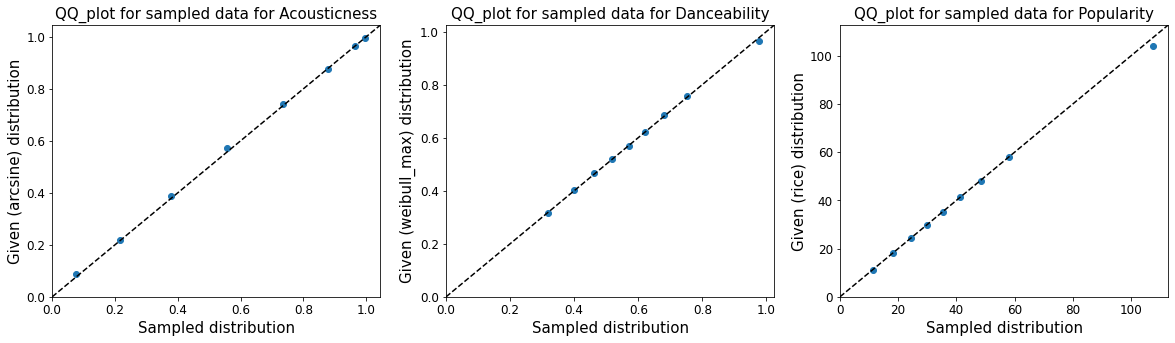

In [23]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
axs=axs.flat
qq_plot(qns(arcsine.rvs(*acoustic_param, size=10000)), qns(sample_acousticness), 'arcsine', title = 'QQ_plot for sampled data for Acousticness', ax=axs[0])
qq_plot(qns(weibull_max.rvs(*dance_param, size=10000)), qns(sample_danceability), 'weibull_max', title = 'QQ_plot for sampled data for Danceability', ax=axs[1])
qq_plot(qns(rice.rvs(*popularity_params, size=10000)), qns(sample_popularity), 'rice', title = 'QQ_plot for sampled data for Popularity', ax=axs[2])
plt.show()

In [24]:
print('For sampled acousticness: ', stats.kstest(sample_acousticness, 'arcsine', acoustic_param, N = 50))
print('For sampled danceability: ',stats.kstest(sample_danceability, 'weibull_max', dance_param, N = 50))
print('For sampled popularity: ',stats.kstest(sample_popularity, 'rice', popularity_params, N = 50))

For sampled acousticness:  KstestResult(statistic=0.008512403147871606, pvalue=0.4609214361678625)
For sampled danceability:  KstestResult(statistic=0.010010987366692814, pvalue=0.2670488128776739)
For sampled popularity:  KstestResult(statistic=0.006893653177923065, pvalue=0.7261222470718245)


In [25]:
print('For sampled acousticness: ', stats.ks_2samp(df['acousticness'].sample(75), sample_acousticness[:75]))
print('For sampled danceability: ', stats.ks_2samp(df['danceability'].sample(75), sample_danceability[:75]))
print('For sampled popularity: ', stats.ks_2samp(df[df['popularity']!=0].sample(75).popularity, sample_popularity[:75]))

For sampled acousticness:  KstestResult(statistic=0.14666666666666667, pvalue=0.3974450299113081)
For sampled danceability:  KstestResult(statistic=0.17333333333333334, pvalue=0.21067424165457352)
For sampled popularity:  KstestResult(statistic=0.17333333333333334, pvalue=0.21067424165457352)


#### Accept rejection sampling for Acousticness

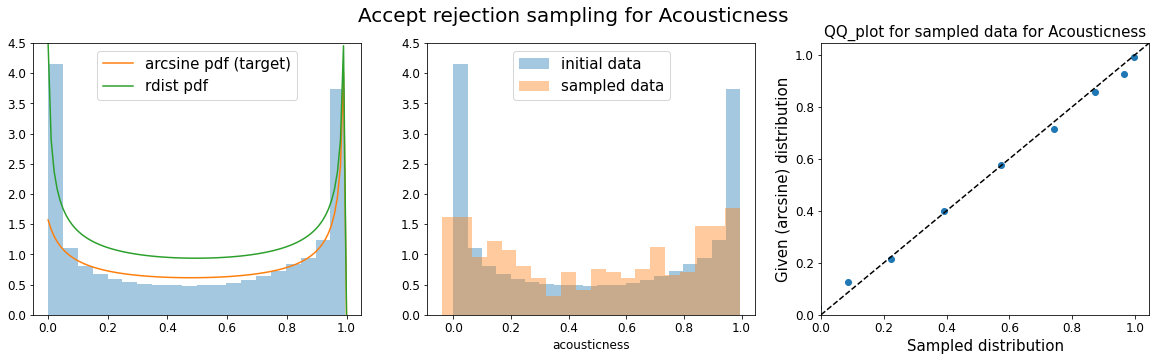

In [29]:
smpl_acousticness=accept_rejection_sampling(arcsine, acoustic_param, rdist, [1.2, 0.495, 5], 0,1, 10000)
fig, axs = plt.subplots(1,3, figsize=(20, 5))
sns.distplot(df[['acousticness']],bins=20,kde=False,norm_hist=True, ax=axs[0], label='')
axs[0].plot(np.linspace(0, 1, num=100), arcsine.pdf(np.linspace(0, 1, num=100), *acoustic_param), label='arcsine pdf (target)')
axs[0].plot(np.linspace(0, 1, num=100),1.3*rdist.pdf(np.linspace(0, 1, num=100),1.2, 0.495, 0.5), label='rdist pdf')
sns.distplot(df['acousticness'],bins=20,kde=False, norm_hist=True,label='initial data', ax=axs[1])
sns.distplot(smpl_acousticness,bins=20,kde=False, norm_hist=True,label='sampled data',ax=axs[1])
axs[0].legend(loc='best',fontsize=15)
axs[1].legend(loc='best',fontsize=15)
axs[0].set_ylim(0,4.5)
axs[1].set_ylim(0,4.5)
qq_plot(qns(arcsine.rvs(*acoustic_param, size=10000)), qns(smpl_acousticness), 'arcsine', title = 'QQ_plot for sampled data for Acousticness', ax=axs[2])
plt.suptitle('Accept rejection sampling for Acousticness', fontsize=20)
plt.savefig(fname='Accept rejection sampling for Acousticness.png', format='png', dpi=500)

In [30]:
smpl_acousticness=np.reshape(smpl_acousticness, (len(smpl_acousticness)))
print('For sampled acousticness and distribution: ', stats.kstest(smpl_acousticness[:75], 'arcsine', acoustic_param, N = 75))
print('For sampled acousticness and real data: ', stats.ks_2samp(df['acousticness'].sample(75).astype('float'), smpl_acousticness[:75]))

For sampled acousticness and distribution:  KstestResult(statistic=0.1295911179455077, pvalue=0.14734795821756436)
For sampled acousticness and real data:  KstestResult(statistic=0.30666666666666664, pvalue=0.0016189617623706498)


#### Accept rejection sampling for Danceability

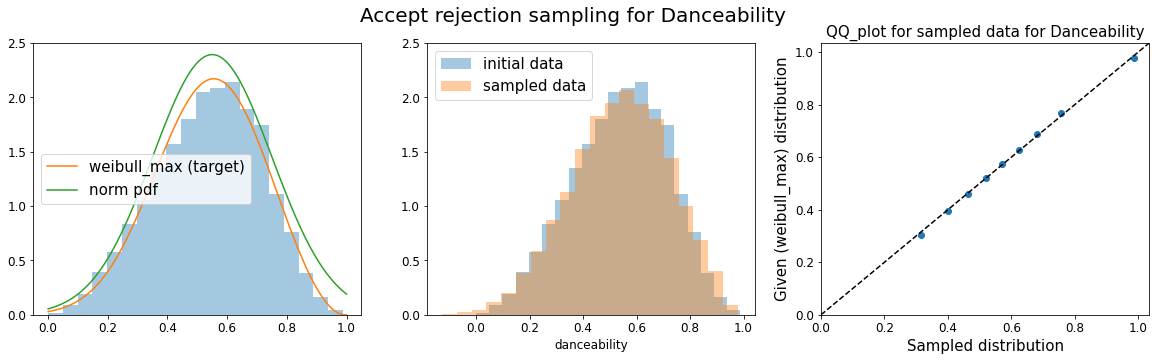

In [31]:
smpl_danceability=accept_rejection_sampling(weibull_max, dance_param, norm, [0.55,0.2], 0,1, 10000)
fig, axs = plt.subplots(1,3, figsize=(20, 5))
sns.distplot(df[['danceability']],bins=20,kde=False,norm_hist=True, ax=axs[0], label='')
axs[0].plot(np.linspace(0, 1, num=100), weibull_max.pdf(np.linspace(0, 1, num=100),*dance_param ), label='weibull_max (target)')
axs[0].plot(np.linspace(0, 1, num=100),1.2*norm.pdf(np.linspace(0, 1, num=100),0.55, 0.2), label='norm pdf')
sns.distplot(df['danceability'],bins=20,kde=False, norm_hist=True,label='initial data', ax=axs[1])
sns.distplot(smpl_danceability,bins=20,kde=False, norm_hist=True,label='sampled data',ax=axs[1])
axs[0].legend(loc='best',fontsize=15)
axs[1].legend(loc='best',fontsize=15)
axs[1].set_ylim(0,2.5)
axs[0].set_ylim(0,2.5)
qq_plot(qns(weibull_max.rvs(*dance_param, size=10000)), qns(smpl_danceability), 'weibull_max', title = 'QQ_plot for sampled data for Danceability', ax=axs[2])
plt.suptitle('Accept rejection sampling for Danceability', fontsize=20)
plt.savefig(fname='Accept rejection sampling for Danceability.png', format='png', dpi=500)

In [32]:
smpl_danceability=np.reshape(smpl_danceability, (len(smpl_danceability)))
print('For sampled danceability and distribution: ', stats.kstest(smpl_danceability[:75], 'weibull_max', dance_param, N = 75))
print('For sampled danceability and real data: ', stats.ks_2samp(df['danceability'].sample(75).astype('float'), smpl_danceability[:75]))

For sampled danceability and distribution:  KstestResult(statistic=0.0905557792452128, pvalue=0.5398203660712461)
For sampled danceability and real data:  KstestResult(statistic=0.18666666666666668, pvalue=0.14686332936650653)


#### Accept rejection sampling for Popularity

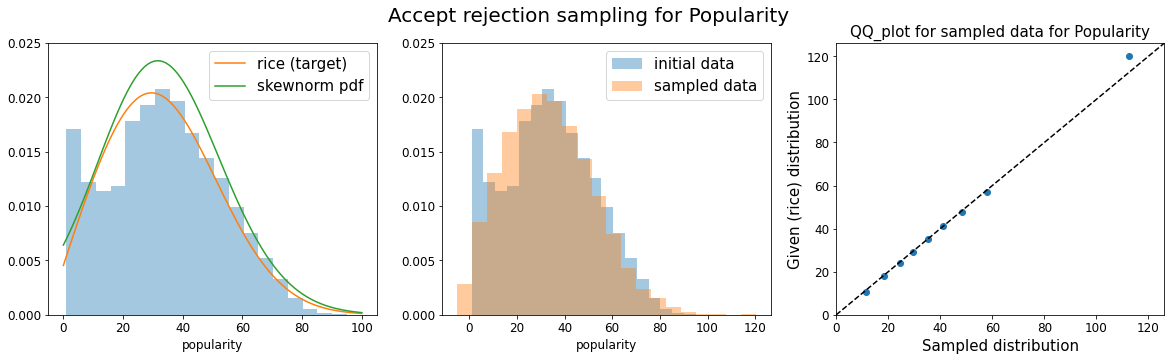

In [33]:
smpl_popularity=accept_rejection_sampling(rice, popularity_params, skewnorm, [1, 19, 25], 0,100, 10000)
fig, axs = plt.subplots(1,3, figsize=(20, 5))
sns.distplot(df[df['popularity']!=0].popularity,bins=20,kde=False,norm_hist=True, ax=axs[0], label='')
axs[0].plot(np.linspace(0, 100, num=100), rice.pdf(np.linspace(0, 100, num=100), *popularity_params), label='rice (target)')
axs[0].plot(np.linspace(0, 100, num=100),1.2*skewnorm.pdf(np.linspace(0, 100, num=100),1, 19, 25), label='skewnorm pdf')
sns.distplot(df[df['popularity']!=0].popularity,bins=20,kde=False, norm_hist=True,label='initial data', ax=axs[1])
sns.distplot(smpl_popularity,bins=20,kde=False, norm_hist=True,label='sampled data',ax=axs[1])
axs[0].legend(loc='best',fontsize=15)
axs[1].legend(loc='best',fontsize=15)
axs[0].set_ylim(0,0.025)
axs[1].set_ylim(0,0.025)
qq_plot(qns(rice.rvs(*popularity_params, size=10000)), qns(smpl_popularity), 'rice', title = 'QQ_plot for sampled data for Popularity', ax=axs[2])
plt.suptitle('Accept rejection sampling for Popularity', fontsize=20)
plt.savefig(fname='Accept rejection sampling for Popularity.png', format='png', dpi=500)

In [34]:
smpl_popularity=np.reshape(smpl_popularity, (len(smpl_popularity)))
print('For sampled popularity and distribution: ', stats.kstest(smpl_popularity[:75], 'rice', popularity_params, N = 75))
print('For sampled popularity and real data: ', stats.ks_2samp(df[df['popularity']!=0].sample(75).popularity.to_numpy(), smpl_popularity[:75]))

For sampled popularity and distribution:  KstestResult(statistic=0.07381666927332964, pvalue=0.7806136976029646)
For sampled popularity and real data:  KstestResult(statistic=0.08, pvalue=0.9717333170639332)


### Step 3. 
Estimate relations between predictors and chosen target variables. At least, they should have significant correlation coefficients. 


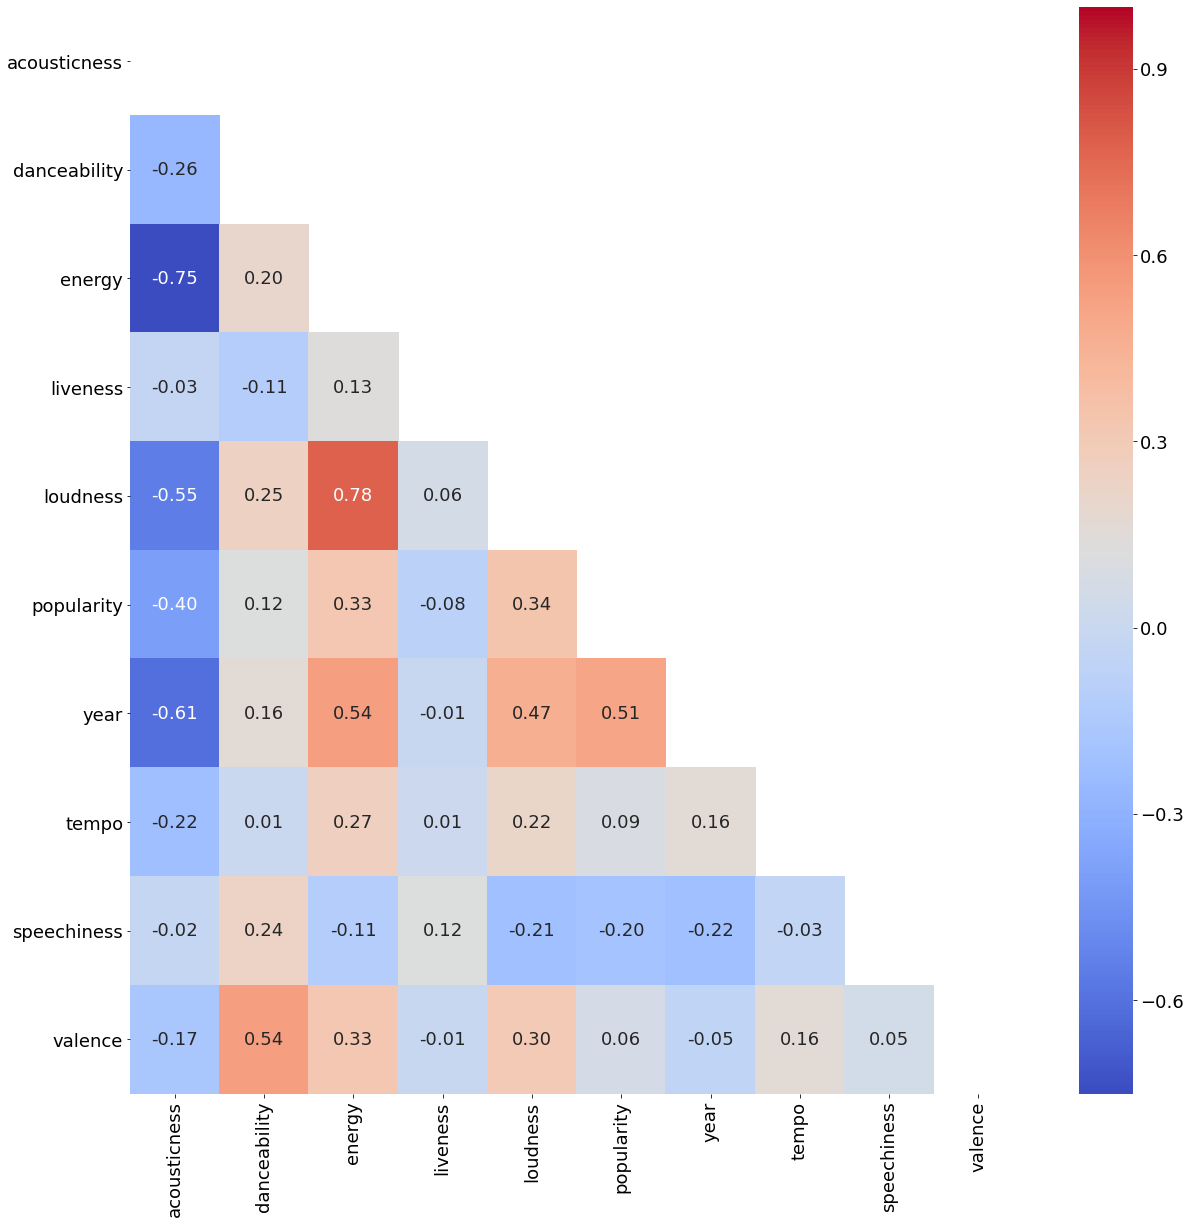

In [35]:
plt.rcParams['font.size'] = 18.0
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', ax=ax, cmap='coolwarm')
plt.show()

In [36]:
# plt.rcParams['font.size'] = 18.0
# plt.figure(dpi=500)
# sns.heatmap(df.corr(method='pearson'),annot=True, square=True, cmap="coolwarm",
#             xticklabels=True, yticklabels=True)
# fig=plt.gcf()
# fig.set_size_inches(25,20)
# plt.savefig(fname='Relations.png', format='png', transparent=True)

Let's get the list of the most correlated items

In [37]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_correlations(df):
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    au_corr=pd.DataFrame(au_corr).reset_index()
    au_corr.columns=['item_1', 'item_2','corr']
    au_corr['abs_corr'] = np.abs(au_corr['corr'])
    au_corr.sort_values('abs_corr',ascending=False, inplace=True)
    au_corr=au_corr.reset_index(drop=True)
    return au_corr

In [38]:
Corr=get_top_correlations(df)
Corr[Corr['abs_corr']>0.2]

,item_1,item_2,corr,abs_corr
0,energy,loudness,0.779267,0.779267
1,acousticness,energy,-0.750852,0.750852
2,acousticness,year,-0.607515,0.607515
3,acousticness,loudness,-0.546639,0.546639
4,energy,year,0.540850,0.540850
5,danceability,valence,0.536713,0.536713
6,popularity,year,0.513227,0.513227
7,loudness,year,0.465189,0.465189
8,acousticness,popularity,-0.396744,0.396744
9,loudness,popularity,0.337194,0.337194


In [39]:
def corr(x, y, alpha):
    r, p = stats.pearsonr(x, y)
    if r == 1:
        return r, None
    r_z = np.arctanh(r)
    # Corresponding standard deviation
    se = 1 / np.sqrt(x.size - 3)
    z = stats.norm.ppf(1 - alpha / 2)
    lo_z, hi_z = r_z - z * se, r_z + z * se
    return r, (lo_z, hi_z)

def correlation_significance(r, n):
    statistic = (r * np.sqrt(n - 2)) / np.sqrt(1 - r ** 2)
    return stats.t.sf(abs(statistic), df=n - 2)

In [40]:
alpha = 0.05
corr_info = []

for i, col1 in enumerate(df.columns):
    if not pd.api.types.is_numeric_dtype(df[col1]):
        continue
    for col2 in df.columns[i + 1:]:
        if not pd.api.types.is_numeric_dtype(df[col2]):
            continue
        r, interval = corr(df[col1], df[col2], alpha)
        interval = f"({interval[0]:.3f}, {interval[1]:.3f})" if interval is not None else ""
        pval = correlation_significance(r, len(df))
        r = f"{r:.3f}"
        corr_info.append((col1, col2, r, interval, pval))

In [41]:
corr_info = pd.DataFrame(corr_info, columns=["Variable 1", "Variable 2", "Correlation", "Confidence interval", "P-value"])
corr_info.set_index(["Variable 1", "Variable 2"])

Correlation Confidence interval        P-value
Variable 1   Variable 2                                                 
acousticness danceability      -0.263    (-0.274, -0.265)   0.000000e+00
             energy            -0.751    (-0.980, -0.970)   0.000000e+00
             liveness          -0.030    (-0.034, -0.025)   1.552619e-35
             loudness          -0.547    (-0.618, -0.609)   0.000000e+00
             popularity        -0.397    (-0.424, -0.415)   0.000000e+00
             year              -0.608    (-0.710, -0.700)   0.000000e+00
             tempo             -0.224    (-0.232, -0.223)   0.000000e+00
             speechiness       -0.022    (-0.027, -0.018)   3.593101e-21
             valence           -0.167    (-0.173, -0.164)   0.000000e+00
danceability energy             0.205      (0.203, 0.212)   0.000000e+00
             liveness          -0.110    (-0.115, -0.106)   0.000000e+00
             loudness           0.250      (0.250, 0.260)   0.000000e+00
             popularity         0.124      (0.120, 0.129)   0.000000e+00
             year               0.159      (0.156, 0.165)   0.000000e+00
             tempo              0.005      (0.001, 0.010)   1.107252e-02
             speechiness        0.240      (0.240, 0.249)   0.000000e+00
             valence            0.537      (0.595, 0.604)   0.000000e+00
energy       liveness           0.135      (0.131, 0.140)   0.000000e+00
             loudness           0.779      (1.039, 1.048)   0.000000e+00
             popularity         0.329      (0.337, 0.346)   0.000000e+00
             year               0.541      (0.601, 0.610)   0.000000e+00
             tempo              0.266      (0.268, 0.278)   0.000000e+00
             speechiness       -0.113    (-0.118, -0.108)   0.000000e+00
             valence            0.326      (0.334, 0.344)   0.000000e+00
liveness     loudness           0.063      (0.058, 0.067)  1.105688e-151
             popularity        -0.079    (-0.084, -0.074)  1.802332e-239
             year              -0.012    (-0.017, -0.007)   3.720650e-07
             tempo              0.009      (0.004, 0.013)   1.683173e-04
             speechiness        0.122      (0.118, 0.127)   0.000000e+00
             valence           -0.006    (-0.010, -0.001)   7.888773e-03
loudness     popularity         0.337      (0.346, 0.356)   0.000000e+00
             year               0.465      (0.499, 0.509)   0.000000e+00
             tempo              0.218      (0.217, 0.226)   0.000000e+00
             speechiness       -0.214    (-0.222, -0.212)   0.000000e+00
             valence            0.303      (0.308, 0.317)   0.000000e+00
popularity   year               0.513      (0.562, 0.572)   0.000000e+00
             tempo              0.095      (0.091, 0.100)   0.000000e+00
             speechiness       -0.195    (-0.203, -0.193)   0.000000e+00
             valence            0.063      (0.059, 0.068)  2.069640e-155
year         tempo              0.162      (0.158, 0.168)   0.000000e+00
             speechiness       -0.216    (-0.224, -0.214)   0.000000e+00
             valence           -0.050    (-0.054, -0.045)   1.229283e-95
tempo        speechiness       -0.034    (-0.038, -0.029)   7.167733e-45
             valence            0.163      (0.160, 0.169)   0.000000e+00
speechiness  valence            0.051      (0.046, 0.055)   1.567940e-99

### Step 4. 
Build a Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm.




Scheme of dependencies:

    The main independent variable is year
    speechiness, loudness, popularity, energy, acousticness  depends on year
    tempo, danceability, valence, popularity, loudness, liveness  depends on energy
    acousticness, loudness depends on tempo
    speechiness, danceability, popularity, acousticness  depends on loudness
    danceability, liveness depends on speechiness
    valence, acousticness depends on danceability
    popularity depends on danceability, acousticness



In [42]:
edges = {
    "year": ['speechiness', 'loudness', 'popularity', 'energy', 'acousticness'],
    "energy": ['tempo', 'danceability', 'valence', 'popularity', 'loudness', 'liveness'],
    "tempo": ['acousticness', 'loudness'],
    "loudness": ['speechiness', 'danceability', 'popularity', 'acousticness'],
    "speechiness": ['danceability', 'liveness'],
    "danceability": ['valence', 'acousticness'],
    "danceability":['popularity'],
    "acousticness": ['popularity']
}

In [43]:
edges_list = []
for out_var, in_vars in edges.items():
    for in_var in in_vars:
        edges_list.append((out_var, in_var))

In [44]:
edges_list


[('year', 'speechiness'),
 ('year', 'loudness'),
 ('year', 'popularity'),
 ('year', 'energy'),
 ('year', 'acousticness'),
 ('energy', 'tempo'),
 ('energy', 'danceability'),
 ('energy', 'valence'),
 ('energy', 'popularity'),
 ('energy', 'loudness'),
 ('energy', 'liveness'),
 ('tempo', 'acousticness'),
 ('tempo', 'loudness'),
 ('loudness', 'speechiness'),
 ('loudness', 'danceability'),
 ('loudness', 'popularity'),
 ('loudness', 'acousticness'),
 ('speechiness', 'danceability'),
 ('speechiness', 'liveness'),
 ('danceability', 'popularity'),
 ('acousticness', 'popularity')]

All continuous distributions should be discretized

In [45]:
transformed_data = copy(df)
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
data_discrete = est.fit_transform(df.values)
transformed_data[transformed_data.columns]= data_discrete

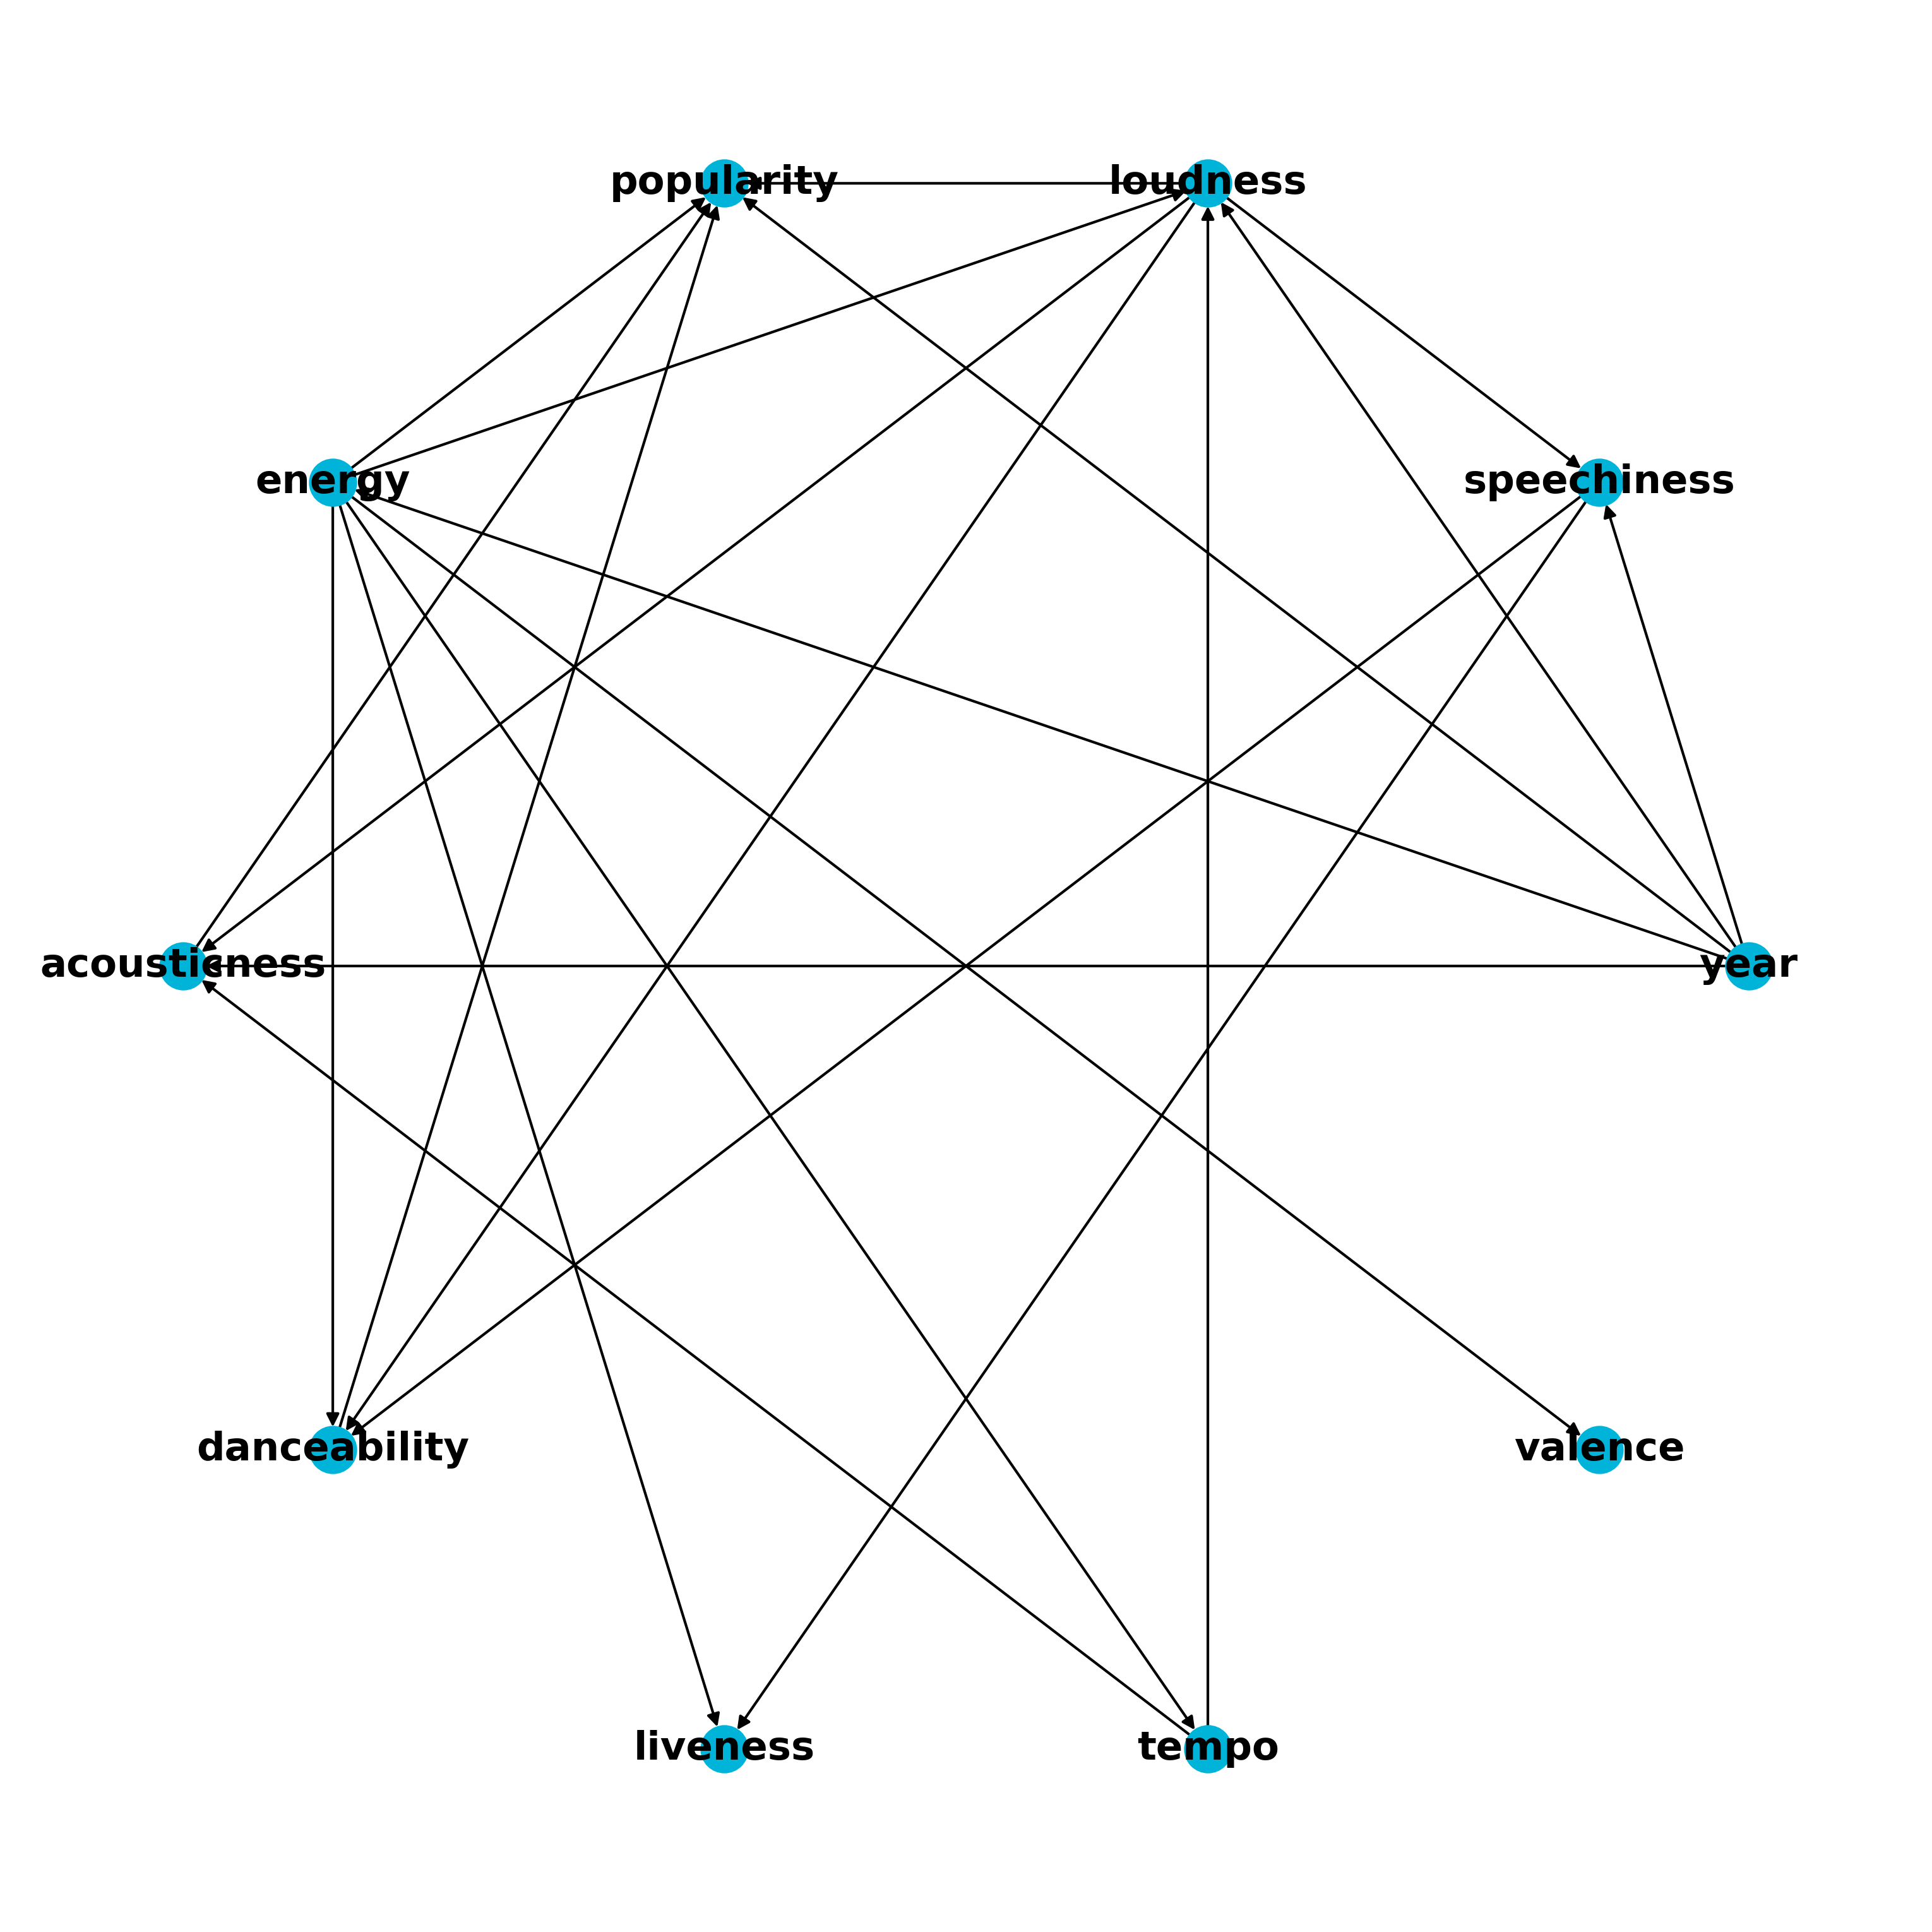

In [46]:
our_network = BayesianModel(edges_list)
G = nx.DiGraph()
G.add_edges_from(our_network.edges())
plt.figure(figsize=(10,10), dpi=300)
pos = nx.layout.circular_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color='#00b4d9', font_size=15)
plt.savefig(fname='Our_structure.png', format='png', transparent=True)
plt.show()

In [47]:
our_network.fit(transformed_data)
print(our_network.check_model())

True


In [48]:
print(f"K2 score of hand-crafted model {K2Score(transformed_data).score(our_network):.2f}")
print(f"BIC score of hand-crafted model {BicScore(transformed_data).score(our_network):.2f}")

K2 score of hand-crafted model -3271482.39
BIC score of hand-crafted model -8691381.38


### Step 5. 
Build a Bayesian network for the same set of variables but using 2 chosen algorithms for structural learning. 


In [49]:
hc = HillClimbSearch(transformed_data, scoring_method=K2Score(transformed_data))

In [50]:
best_model_K2 = hc.estimate()

  0%|          | 22/1000000 [00:08<104:23:30,  2.66it/s]


In [51]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(best_model_K2.edges())

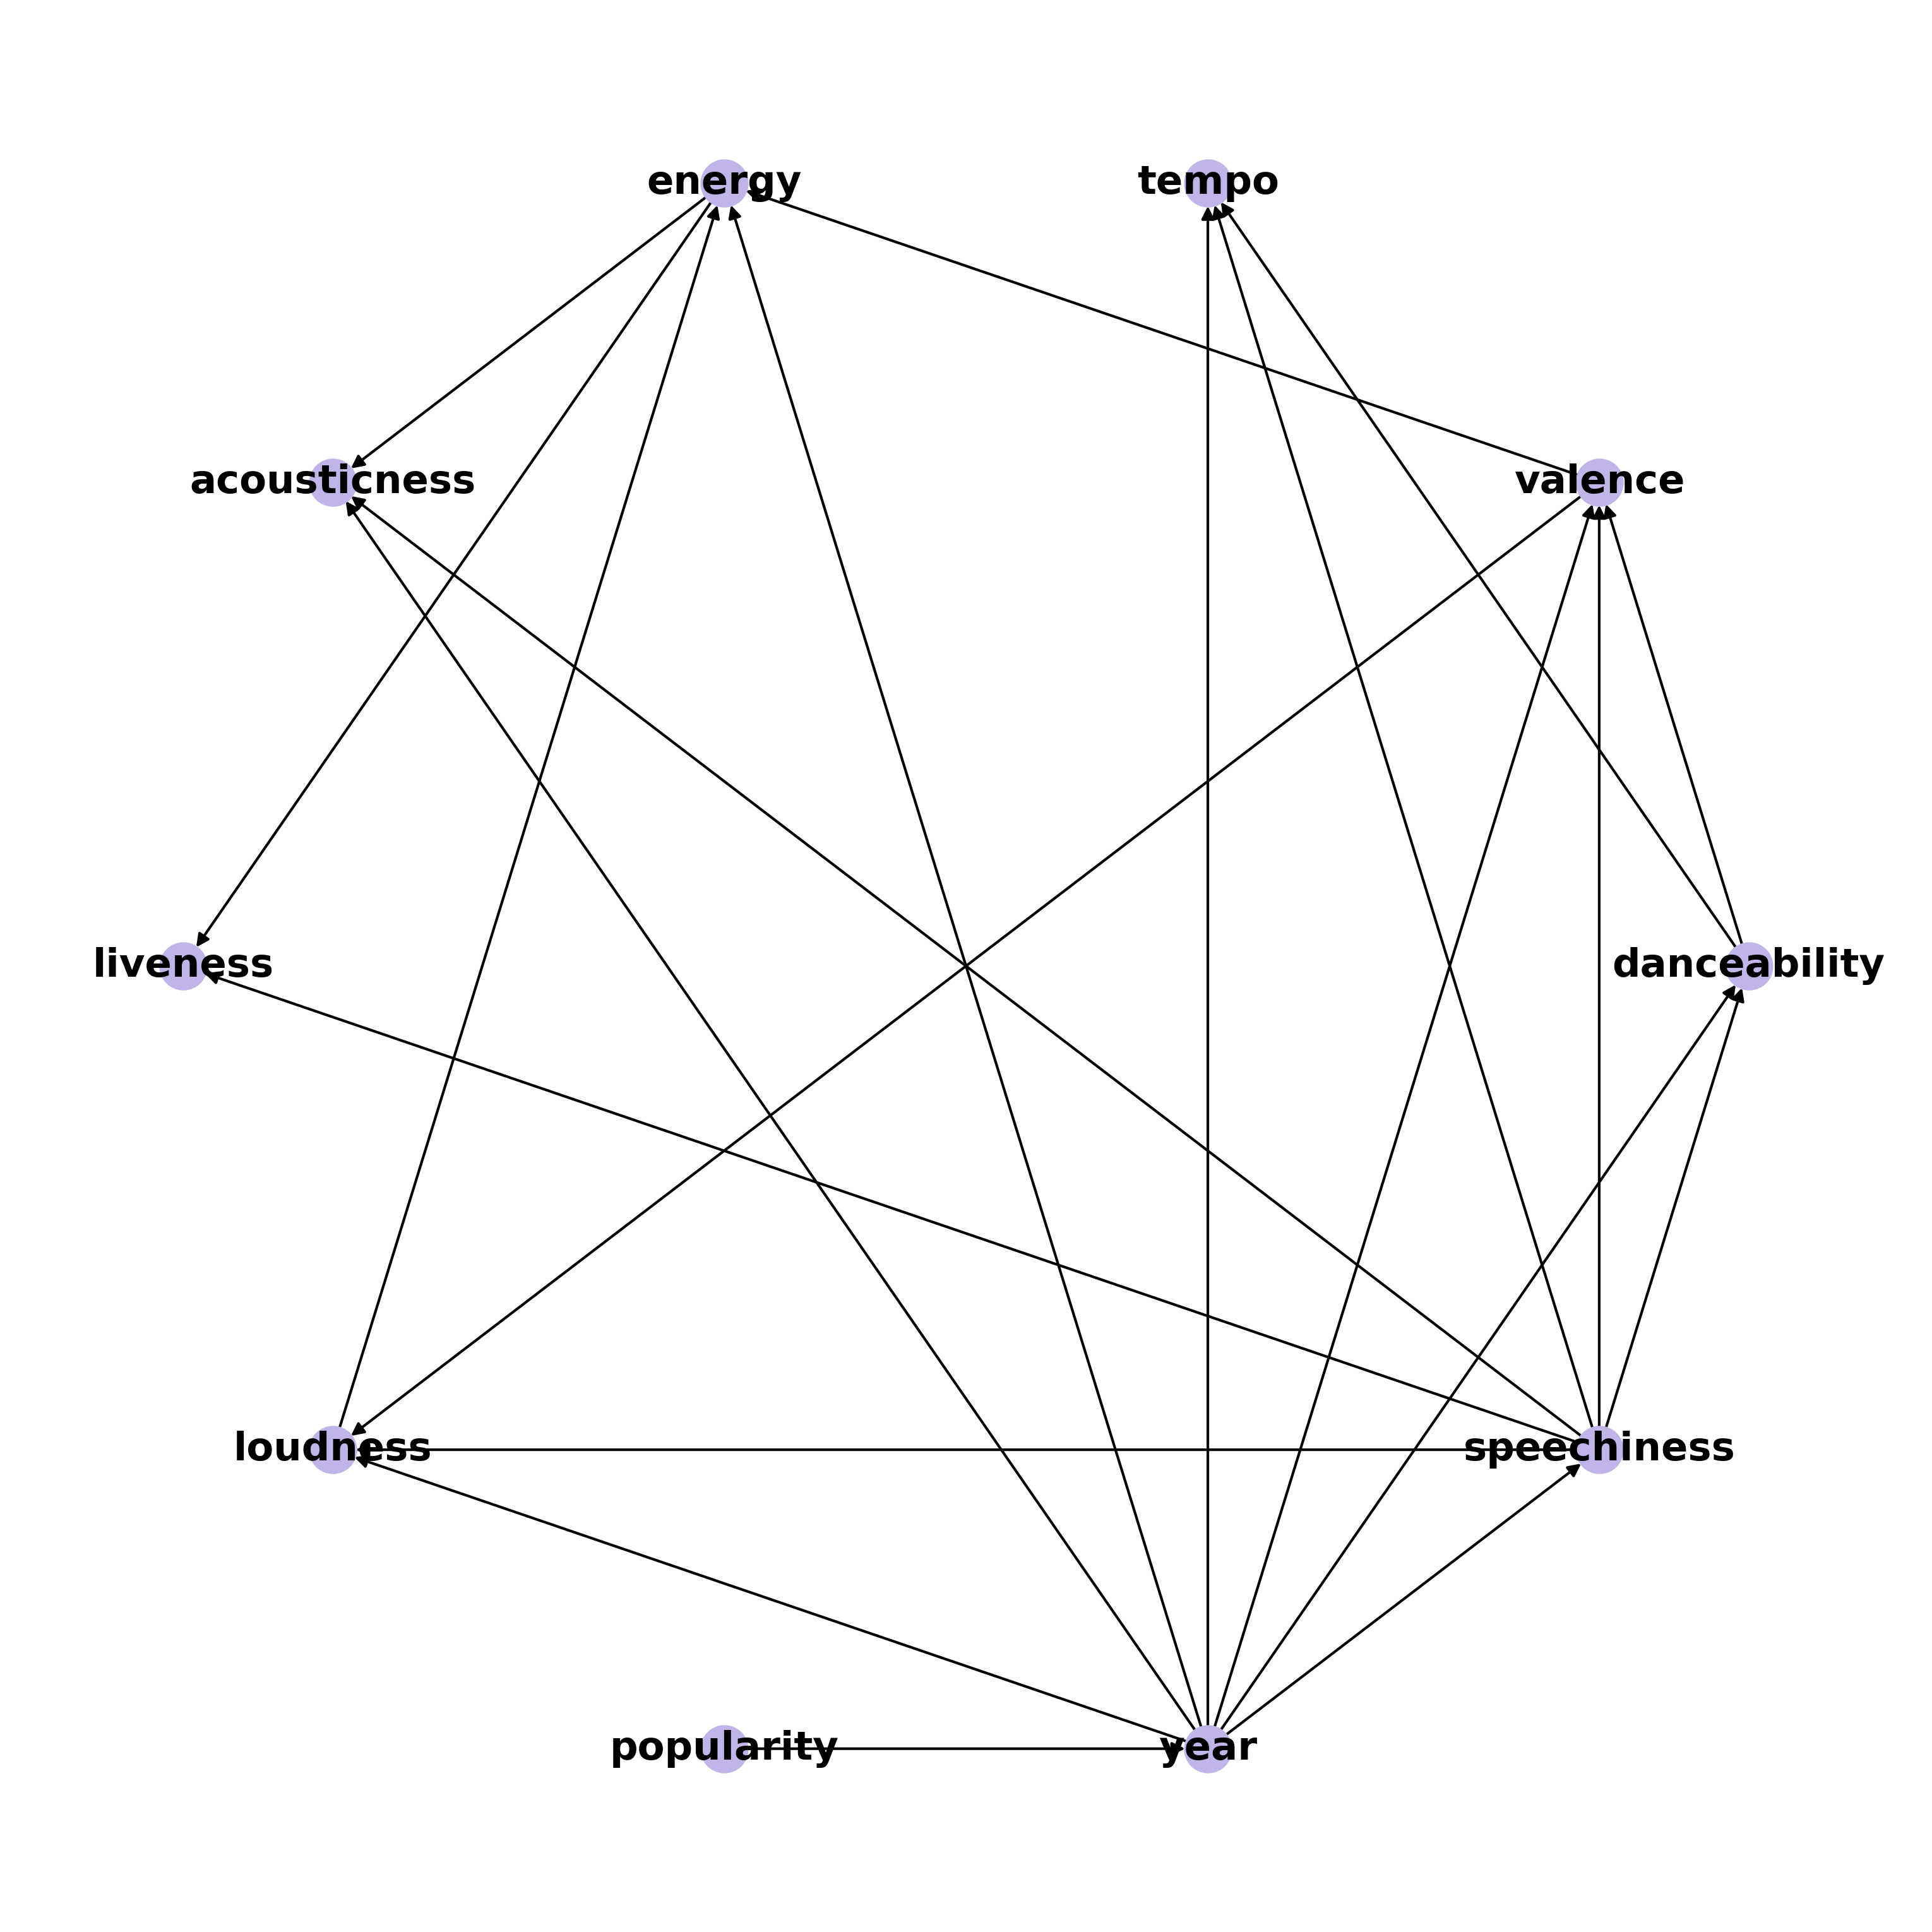

In [52]:
pos = nx.layout.circular_layout(G_K2)
plt.figure(figsize=(10,10), dpi=300)
nx.draw(G_K2, pos, with_labels=True, font_weight='bold', node_color='#c0b4e9', font_size=15)
plt.savefig(fname='K2_structure.png', format='png', transparent=True)
plt.show()

In [53]:
blacklist = [(x, y) for x in transformed_data.columns.to_list() for y in ['year'] if x != y]
blacklist

[('acousticness', 'year'),
 ('danceability', 'year'),
 ('energy', 'year'),
 ('liveness', 'year'),
 ('loudness', 'year'),
 ('popularity', 'year'),
 ('tempo', 'year'),
 ('speechiness', 'year'),
 ('valence', 'year')]

In [54]:
best_model_K2 = hc.estimate(black_list=blacklist)

  0%|          | 23/1000000 [00:08<106:53:27,  2.60it/s]


In [55]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(best_model_K2.edges())

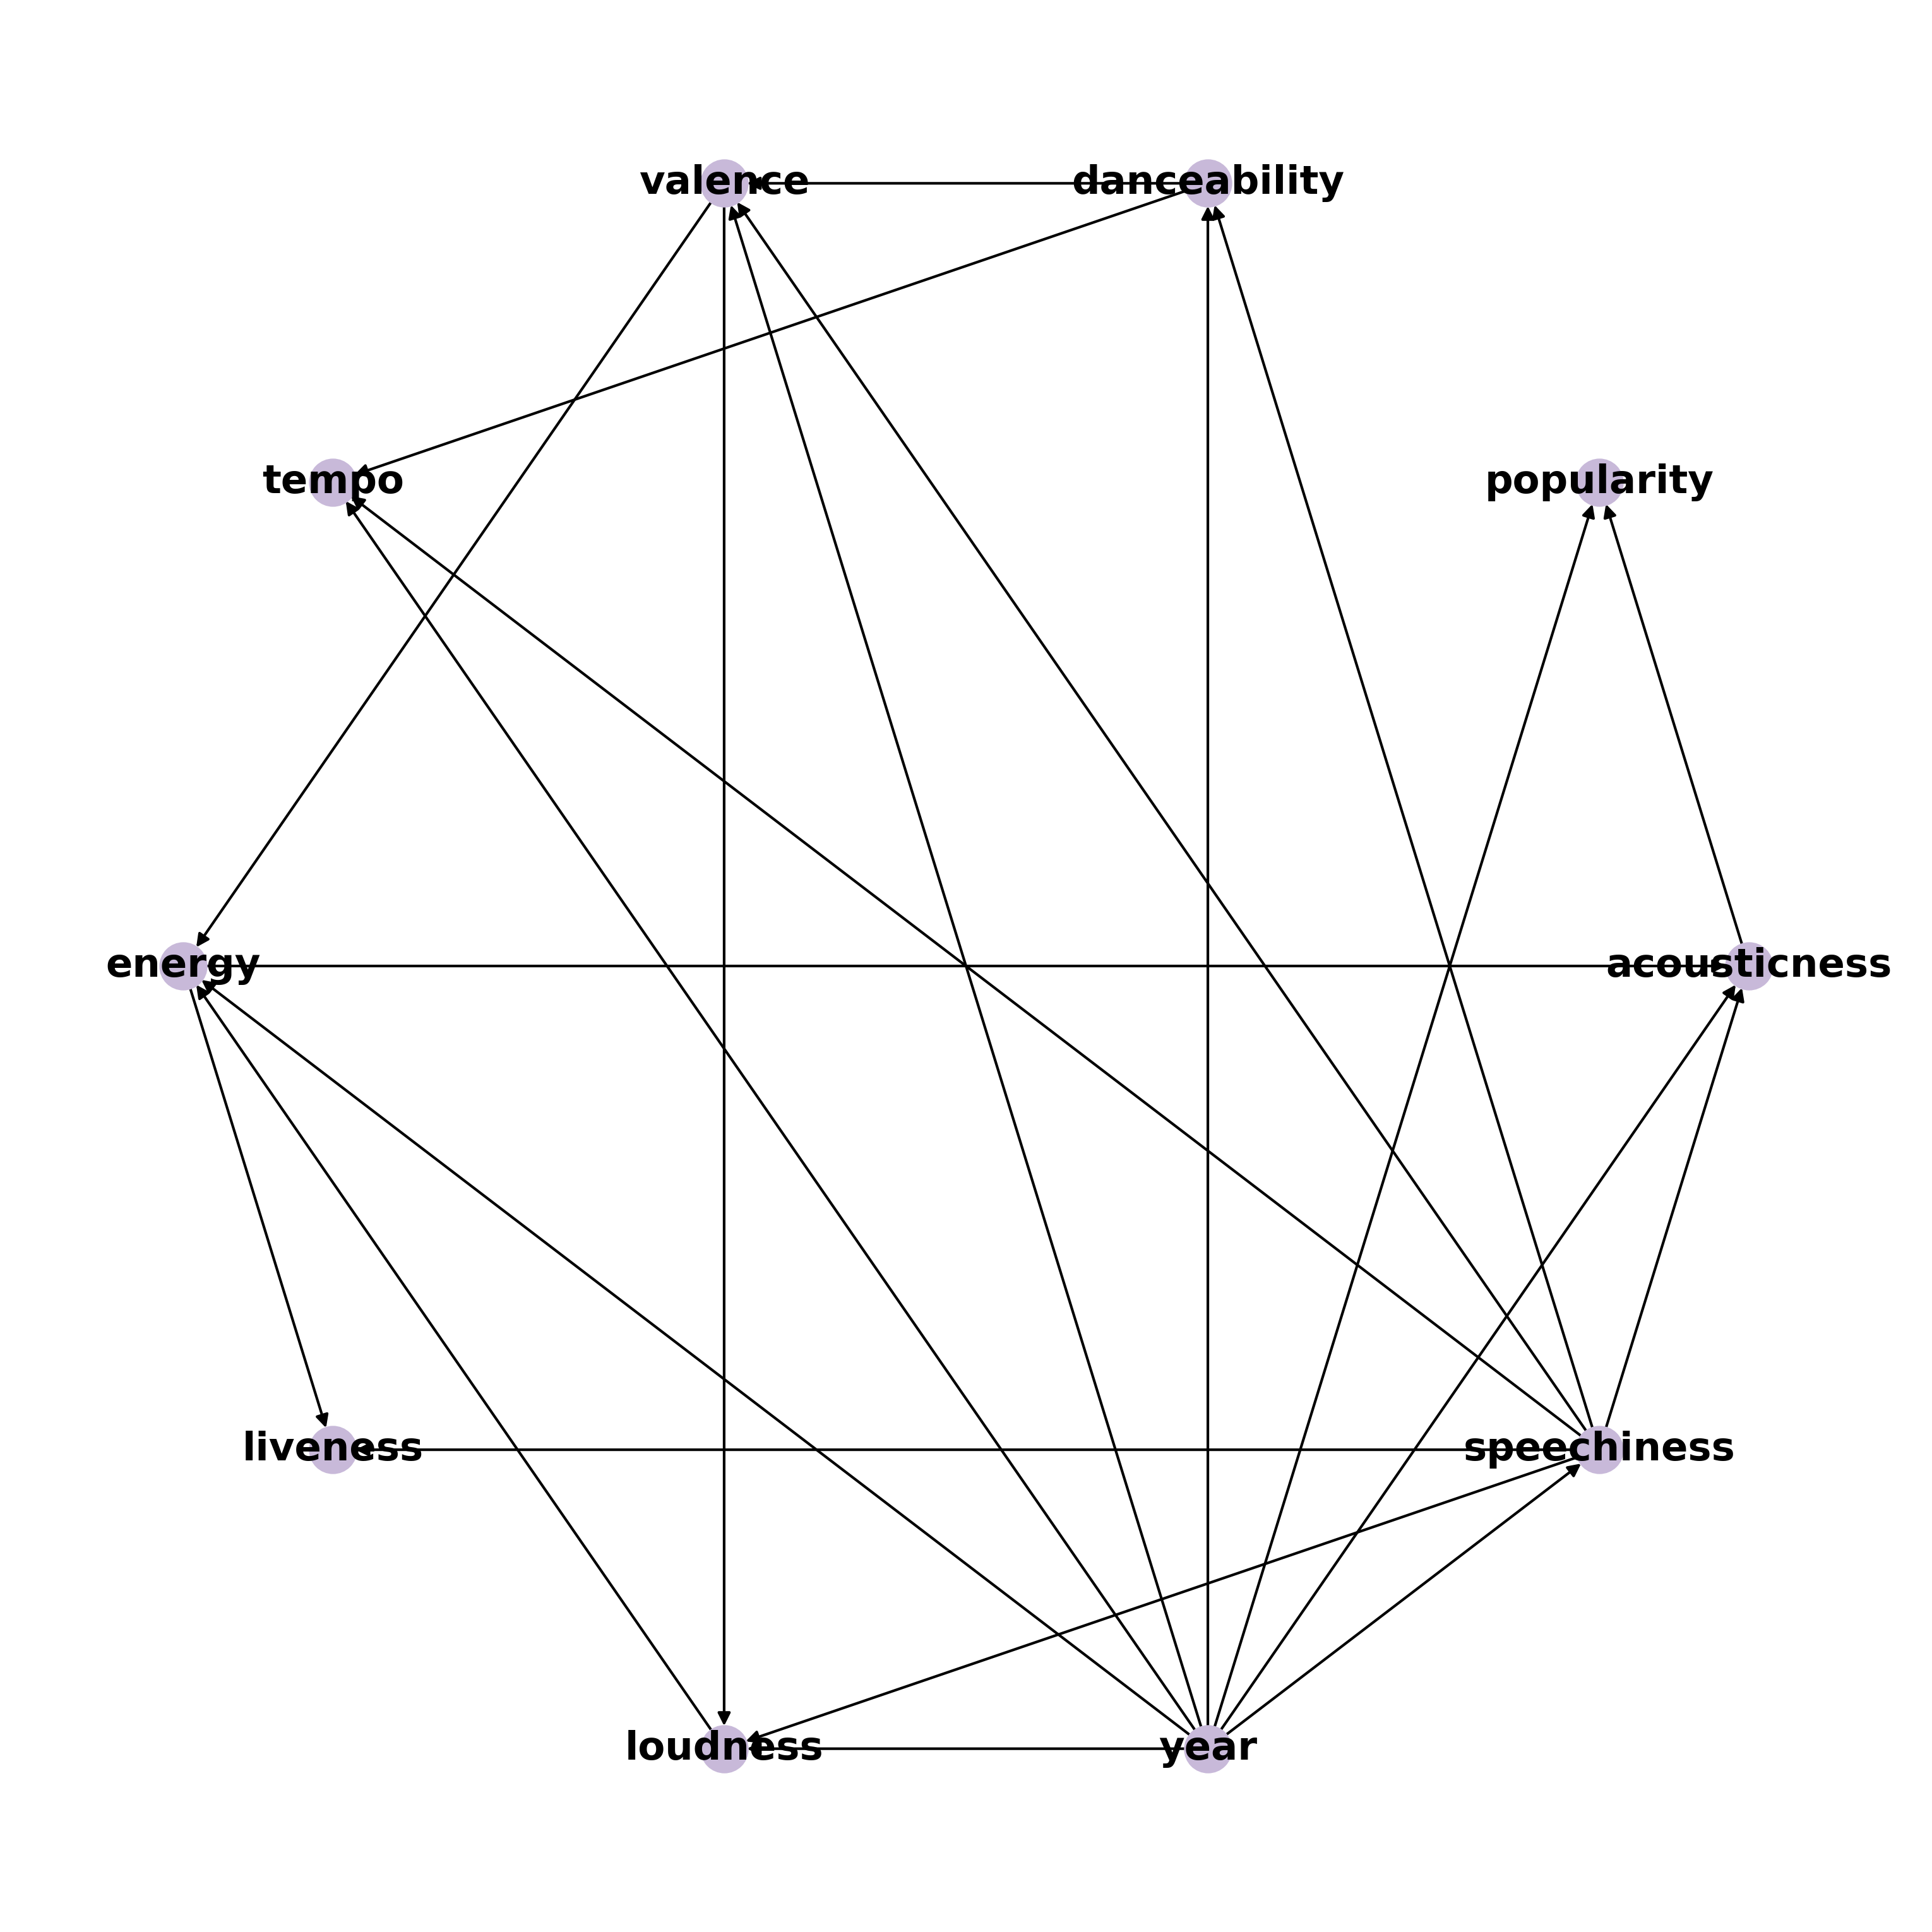

In [56]:
pos = nx.layout.circular_layout(G_K2)
plt.figure(figsize=(10,10), dpi=300)
nx.draw(G_K2, pos, with_labels=True, font_weight='bold', node_color='#c8b9d9', font_size=15)
plt.savefig(fname='K2_structure.png', format='png', transparent=True)
plt.show()

In [57]:
print(f"K2 score of G_K2Score model {K2Score(transformed_data).score(best_model_K2):.2f}")
print(f"BIC score of G_K2Score model {BicScore(transformed_data).score(best_model_K2):.2f}")

K2 score of G_K2Score model -3119443.77
BIC score of G_K2Score model -3335531.79


In [58]:
hc_BicScore = HillClimbSearch(transformed_data, scoring_method=BicScore(transformed_data))
best_model_BicScore = hc_BicScore.estimate(black_list=blacklist)

  0%|          | 23/1000000 [00:08<105:36:13,  2.63it/s]


In [59]:
G_BicScore = nx.DiGraph()
G_BicScore.add_edges_from(best_model_BicScore.edges())

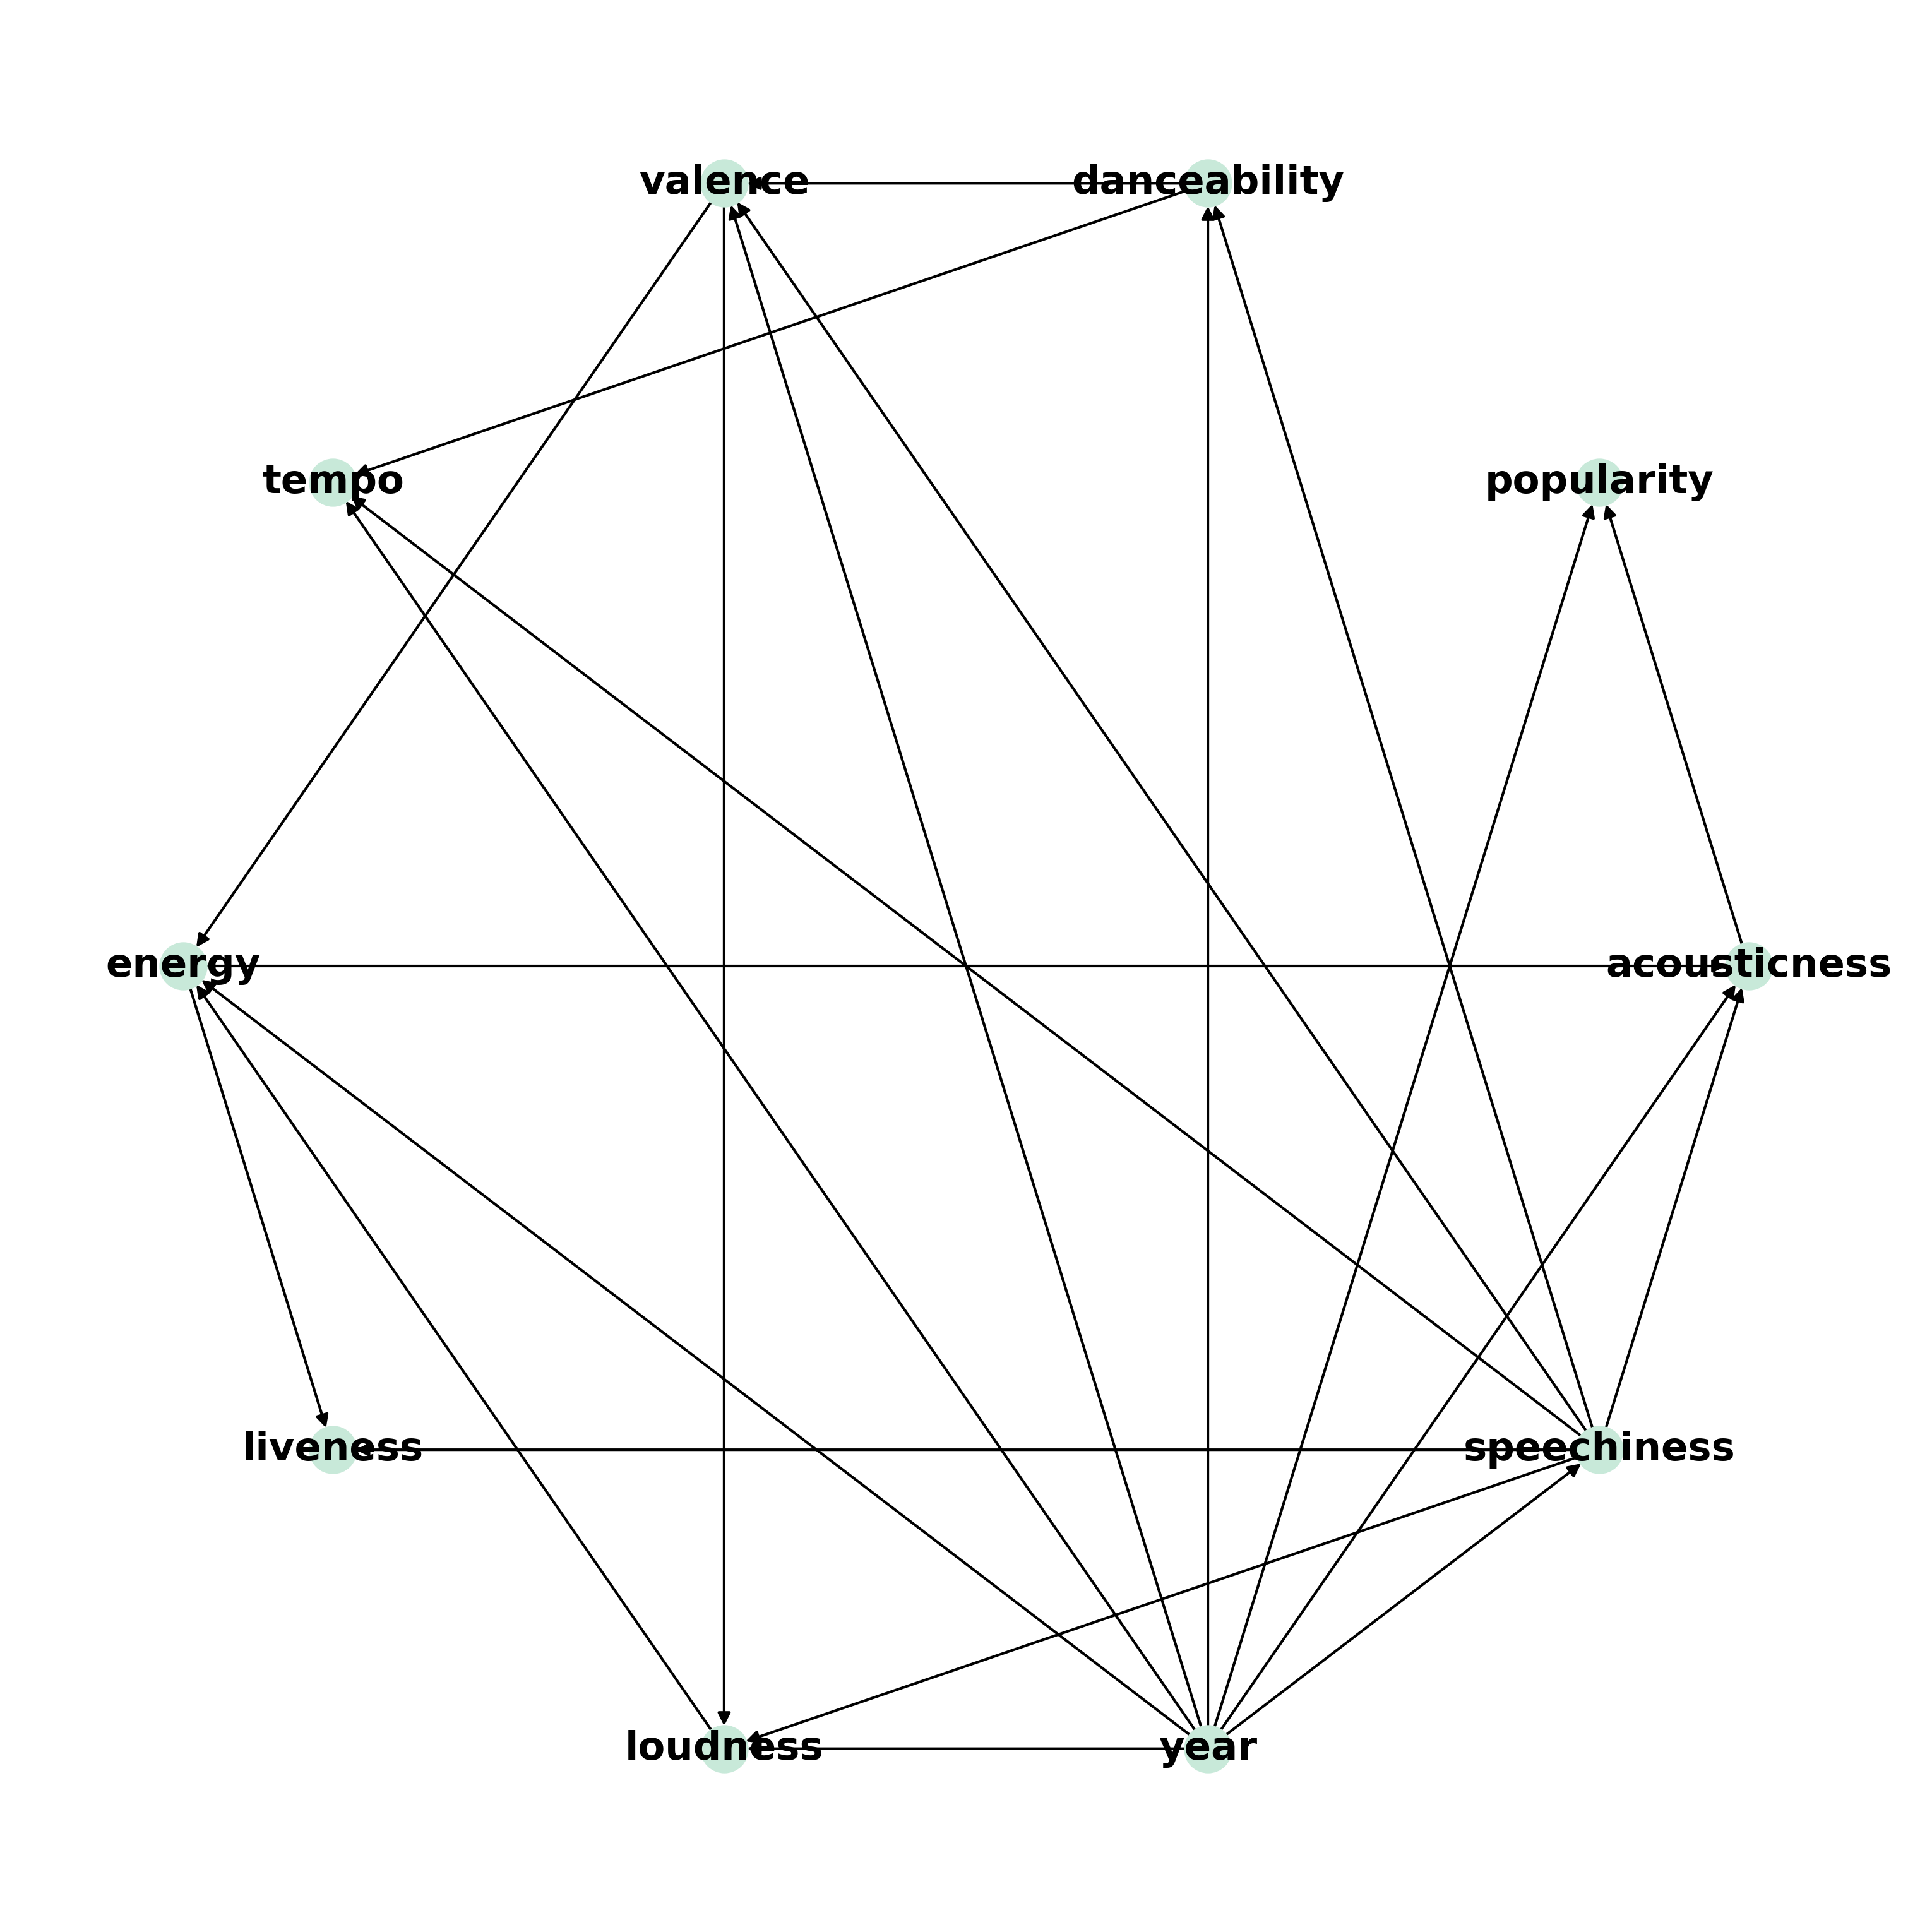

In [60]:
pos = nx.layout.circular_layout(G_BicScore)
plt.figure(figsize=(10,10), dpi=300)
nx.draw(G_BicScore, pos, with_labels=True, font_weight='bold', node_color='#c8e9d9', font_size=15)
plt.savefig(fname='BicScore_structure.png', format='png', transparent=True)
plt.show()

In [61]:
print(f"K2 score of G_BicScore model {K2Score(transformed_data).score(best_model_BicScore):.2f}")
print(f"BIC score of G_BicScore model {BicScore(transformed_data).score(best_model_BicScore):.2f}")

K2 score of G_BicScore model -3119443.77
BIC score of G_BicScore model -3335531.79


### Step 6.
Analyze a quality of sampled target variables from the point of view of problem statement (e.g. prediction, gap filling, synthetic generation).

In [62]:
def sampling (bn: DAG, data: pd.DataFrame, n: int = 100):
    bn_new = BayesianModel(bn.edges())
    bn_new.fit(data)
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n, return_type='dataframe')
    return sample

In [63]:
def draw_comparative_hist (parametr: str, original_data: pd.DataFrame, 
                           data_sampled1: pd.DataFrame, 
                           data_sampled2: pd.DataFrame, 
                           data_sampled3: pd.DataFrame):
    final_df = pd.DataFrame()
    df1 = pd.DataFrame()
    df1[parametr] = original_data[parametr]
    df1['Data'] = 'Original data'
    df1['Probability'] = df1[parametr].apply(lambda x: (df1.groupby(parametr)[parametr].count()[x])/original_data.shape[0])
    
    df2 = pd.DataFrame()
    df2[parametr] = data_sampled1[parametr]
    df2['Data'] = 'K2Score'
    df2['Probability'] = df2[parametr].apply(lambda x: (df2.groupby(parametr)[parametr].count()[x])/data_sampled1.shape[0])

    df3 = pd.DataFrame()
    df3[parametr] = data_sampled2[parametr]
    df3['Data'] = 'BicScore'
    df3['Probability'] = df3[parametr].apply(lambda x: (df3.groupby(parametr)[parametr].count()[x])/data_sampled2.shape[0])

    df4 = pd.DataFrame()
    df4[parametr] = data_sampled3[parametr]
    df4['Data'] = 'Our structure'
    df4['Probability'] = df4[parametr].apply(lambda x: (df4.groupby(parametr)[parametr].count()[x])/data_sampled3.shape[0])

    final_df = pd.concat([df1, df2, df3, df4])
    sns.color_palette("Set2")
    sns.barplot(x=parametr, y="Probability", hue="Data", data=final_df)
    plt.legend(loc='best')
    plt.show()

Sampling from the models and comparing

In [64]:
sample_k2 = sampling(best_model_K2, transformed_data, transformed_data.shape[0])

Generating for node: popularity: 100%|██████████| 10/10 [00:29<00:00,  2.97s/it] 


In [65]:
sample_Bic = sampling(best_model_BicScore, transformed_data, transformed_data.shape[0])

Generating for node: popularity: 100%|██████████| 10/10 [00:29<00:00,  2.91s/it] 


In [66]:
sample_munual = sampling(our_network, transformed_data, transformed_data.shape[0])

Generating for node: popularity: 100%|██████████| 10/10 [11:04<00:00, 66.44s/it] 


In [68]:
targets = ['acousticness', 'danceability', 'popularity']

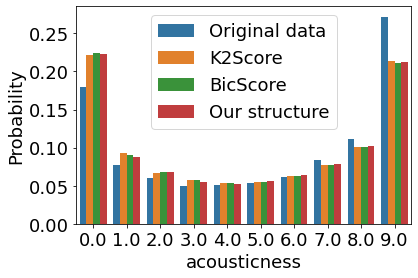

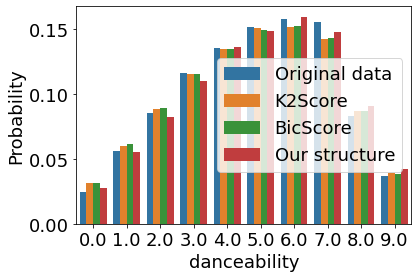

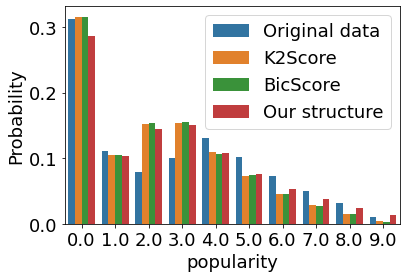

In [69]:
for tar in targets:  
    draw_comparative_hist(tar, transformed_data[:50000], sample_k2[:50000], sample_Bic[:50000], sample_munual[:50000])

In [78]:
def Anderson_Darling_test(data, sample, str):
    and_dar = stats.anderson_ksamp([data, sample])
    print('Two-sample Anderson-Darling test:')
    print('statistic = %.3f'%and_dar[0], 'p-value = %.3f'%and_dar[-1])
    if and_dar[-1] > 0.05:
        print('k-samples are drawn from the same population')
    else:
        print('H0: two samples are drawn from an identical distribution is rejected')

In [80]:
for tar in targets:
    samples = [sample_k2[tar].sample(1000), sample_Bic[tar].sample(1000), sample_munual[tar].sample(1000)]
    for i, sample in enumerate(samples):
        print(f'For {tar}')
        Anderson_Darling_test(transformed_data[tar].sample(1000), sample, tar)

For acousticness
Two-sample Anderson-Darling test:
statistic = -0.907 p-value = 0.250
k-samples are drawn from the same population
For acousticness
Two-sample Anderson-Darling test:
statistic = -0.493 p-value = 0.250
k-samples are drawn from the same population
For acousticness
Two-sample Anderson-Darling test:
statistic = -0.523 p-value = 0.250
k-samples are drawn from the same population
For danceability
Two-sample Anderson-Darling test:
statistic = -1.011 p-value = 0.250
k-samples are drawn from the same population
For danceability
Two-sample Anderson-Darling test:
statistic = -0.597 p-value = 0.250
k-samples are drawn from the same population
For danceability
Two-sample Anderson-Darling test:
statistic = -1.204 p-value = 0.250
k-samples are drawn from the same population
For popularity
Two-sample Anderson-Darling test:
statistic = -0.596 p-value = 0.250
k-samples are drawn from the same population
For popularity
Two-sample Anderson-Darling test:
statistic = -1.101 p-value = 0.250
k

In [81]:
inv_sample_Bic=copy(sample_Bic)
inv_sample_k2 =copy(sample_k2)
inv_sample_munual=copy(sample_munual)

In [82]:
inv_sample_Bic[df.columns]=est.inverse_transform(sample_Bic[df.columns].values)
inv_sample_k2[df.columns]=est.inverse_transform(sample_k2[df.columns].values)
inv_sample_munual[df.columns]=est.inverse_transform(sample_munual[df.columns].values)

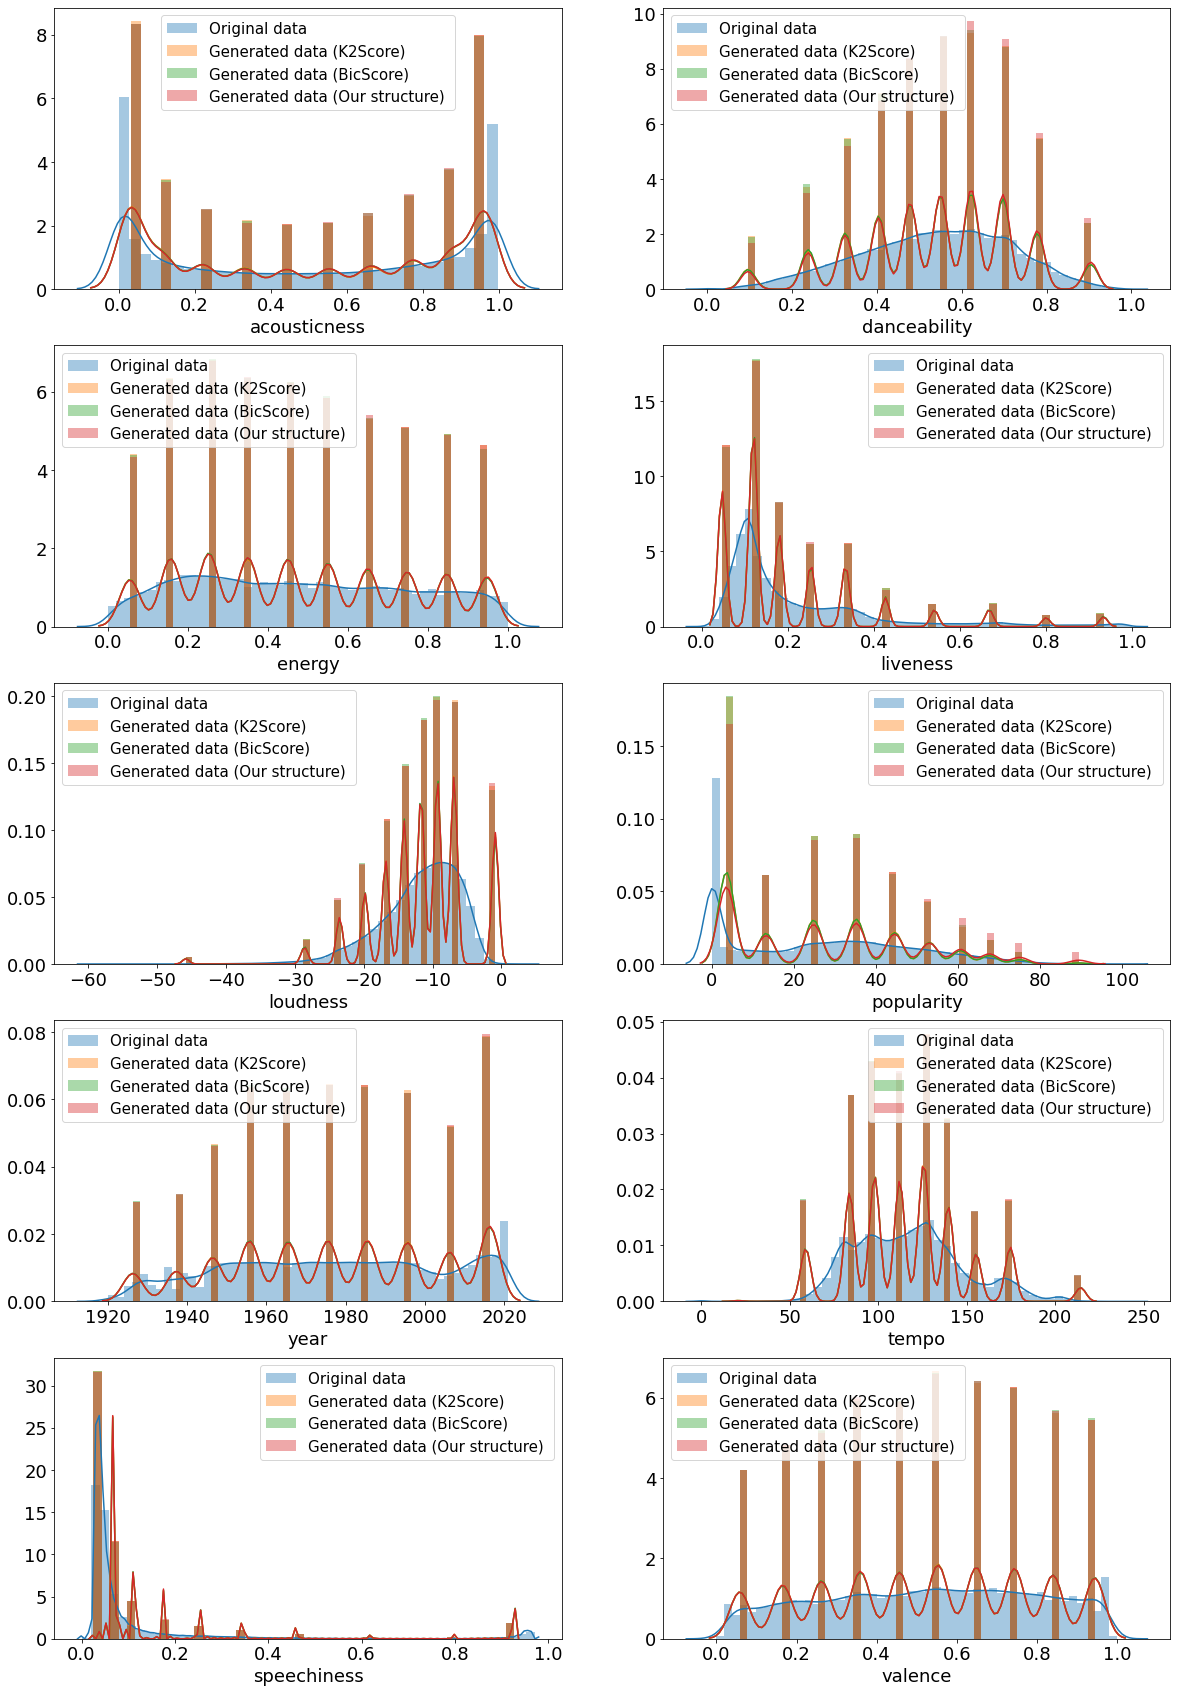

In [92]:
fig, axs = plt.subplots(5,2, figsize=(20,30))
axs=axs.flat
for num, col in enumerate(df.columns):
    sns.distplot(df[col], label='Original data', ax=axs[num])
    sns.distplot(inv_sample_k2[col], label='Generated data (K2Score)', ax=axs[num])
    sns.distplot(inv_sample_Bic[col], label='Generated data (BicScore) ', ax=axs[num])
    sns.distplot(inv_sample_munual[col], label='Generated data (Our structure) ', ax=axs[num])
    axs[num].legend(loc='best',fontsize=15)
plt.show()

In [138]:
statistical_tests(inv_sample_Bic['acousticness'].sample(1000), 'arcsine', acoustic_param, alpha = 0.05, N = 50)

Kolmogorov test passed. Under the null hypothesis,
 the two arcsine distributions are identical

 KstestResult(statistic=0.17114200956966413, pvalue=0.09471208745525439)


Cramer-von-Mises test passed. Hypothesis about that distribution 
 have cumulative arcsine distribution is true

 CramerVonMisesResult(statistic=0.37802624971271875, pvalue=0.0823017929047487)


In [137]:
statistical_tests(inv_sample_Bic['danceability'].sample(1000), 'weibull_max', dance_param, alpha = 0.05, N = 50)

Kolmogorov test passed. Under the null hypothesis,
 the two weibull_max distributions are identical

 KstestResult(statistic=0.1371731524238925, pvalue=0.27741792084684425)


Cramer-von-Mises test passed. Hypothesis about that distribution 
 have cumulative weibull_max distribution is true

 CramerVonMisesResult(statistic=0.29586371655936766, pvalue=0.13872888693670016)


In [143]:
statistical_tests(inv_sample_Bic['popularity'].sample(100), 'rice', popularity_params, alpha = 0.05, N = 50)

Kolmogorov test failed. Hypothesis about rice is false

 KstestResult(statistic=0.22193231726628726, pvalue=0.012094277478324145)


Cramer-von-Mises failed. We reject the null hypothesis 
 that the observed sample is drawn from a rice distribution

 CramerVonMisesResult(statistic=0.7470235386299174, pvalue=0.009493374215953754)


In [153]:
statistical_tests(inv_sample_k2['acousticness'].sample(1000), 'arcsine', acoustic_param, alpha = 0.05, N = 50)


Kolmogorov test passed. Under the null hypothesis,
 the two arcsine distributions are identical

 KstestResult(statistic=0.17114200956966413, pvalue=0.09471208745525439)


Cramer-von-Mises failed. We reject the null hypothesis 
 that the observed sample is drawn from a arcsine distribution

 CramerVonMisesResult(statistic=0.5819208479716068, pvalue=0.024402937700605642)


In [154]:
statistical_tests(inv_sample_k2['danceability'].sample(1000), 'weibull_max', dance_param, alpha = 0.05, N = 50)


Kolmogorov test passed. Under the null hypothesis,
 the two weibull_max distributions are identical

 KstestResult(statistic=0.17844118452840063, pvalue=0.07284593473212764)


Cramer-von-Mises test passed. Hypothesis about that distribution 
 have cumulative weibull_max distribution is true

 CramerVonMisesResult(statistic=0.4495609092006998, pvalue=0.053215913562749684)


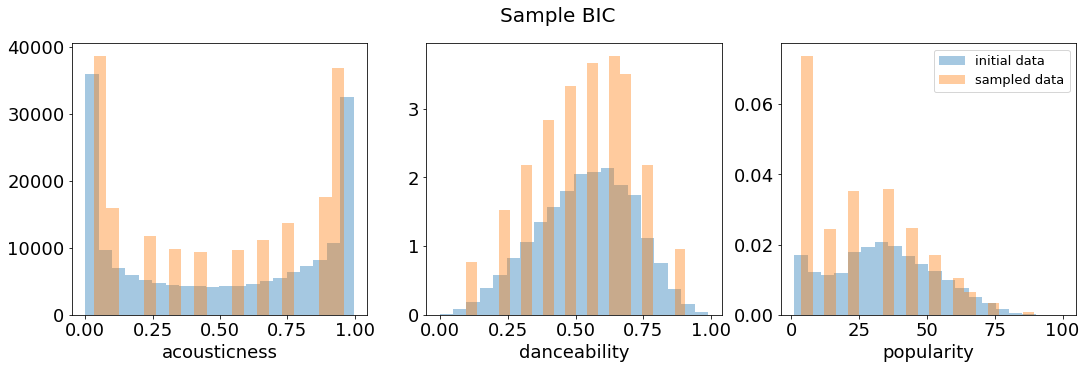

In [155]:
fig, axs = plt.subplots(1,3, figsize=(18, 5))
axs=axs.flat
sns.distplot(df['acousticness'],bins=20,kde=False, norm_hist=False, ax=axs[0], label='initial data')
sns.distplot(inv_sample_Bic['acousticness'],bins=20,kde=False,norm_hist=False,ax=axs[0], label='sampled data')
sns.distplot(df['danceability'],bins=20,kde=False, norm_hist=True, ax=axs[1], label='initial data')
sns.distplot(inv_sample_Bic['danceability'],bins=20,kde=False,norm_hist=True,ax=axs[1], label='sampled data')
sns.distplot(df[df['popularity']!=0].popularity.astype('float'),bins=20,kde=False, norm_hist=True, ax=axs[2], label='initial data')
sns.distplot(inv_sample_Bic['popularity'],bins=20,kde=False,norm_hist=True,ax=axs[2], label='sampled data')
plt.legend(loc='best',fontsize=13)
plt.suptitle('Sample BIC', fontsize=20)
plt.show()

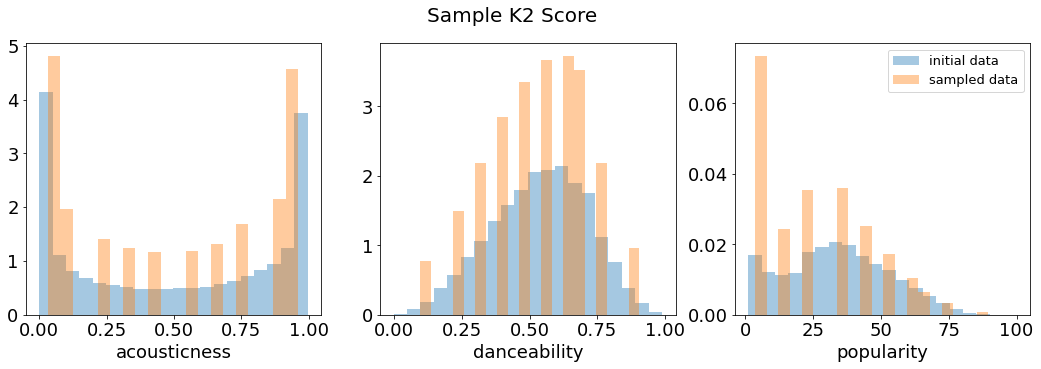

In [149]:
fig, axs = plt.subplots(1,3, figsize=(18, 5))
axs=axs.flat
sns.distplot(df['acousticness'],bins=20,kde=False, norm_hist=True, ax=axs[0], label='initial data')
sns.distplot(inv_sample_k2['acousticness'],bins=20,kde=False,norm_hist=True,ax=axs[0], label='sampled data')
sns.distplot(df['danceability'],bins=20,kde=False, norm_hist=True, ax=axs[1], label='initial data')
sns.distplot(inv_sample_k2['danceability'],bins=20,kde=False,norm_hist=True,ax=axs[1], label='sampled data')
sns.distplot(df[df['popularity']!=0].popularity.astype('float'),bins=20,kde=False, norm_hist=True, ax=axs[2], label='initial data')
sns.distplot(inv_sample_k2['popularity'],bins=20,kde=False,norm_hist=True,ax=axs[2], label='sampled data')
plt.legend(loc='best',fontsize=13)
plt.suptitle('Sample K2 Score', fontsize=20)
plt.show()

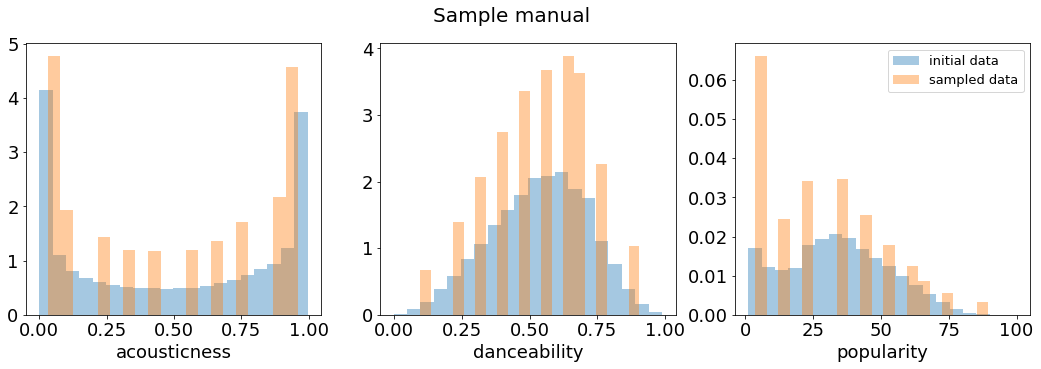

In [152]:
fig, axs = plt.subplots(1,3, figsize=(18, 5))
axs=axs.flat
sns.distplot(df['acousticness'],bins=20,kde=False, norm_hist=True, ax=axs[0], label='initial data')
sns.distplot(inv_sample_munual['acousticness'],bins=20,kde=False,norm_hist=True,ax=axs[0], label='sampled data')
sns.distplot(df['danceability'],bins=20,kde=False, norm_hist=True, ax=axs[1], label='initial data')
sns.distplot(inv_sample_munual['danceability'],bins=20,kde=False,norm_hist=True,ax=axs[1], label='sampled data')
sns.distplot(df[df['popularity']!=0].popularity.astype('float'),bins=20,kde=False, norm_hist=True, ax=axs[2], label='initial data')
sns.distplot(inv_sample_munual['popularity'],bins=20,kde=False,norm_hist=True,ax=axs[2], label='sampled data')
plt.legend(loc='best',fontsize=13)
plt.suptitle('Sample manual', fontsize=20)
plt.show()